# Information Globale

## Importation

In [108]:
#Générique Importation
import pandas as pd
import numpy as np
import seaborn as sns
import datetime

#Générique Importation
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error

#
from vacances_scolaires_france import SchoolHolidayDates

#Sclaing
from sklearn.preprocessing import RobustScaler

#Machine Learning
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor

from lineartree           import LinearBoostRegressor
from sklearn.linear_model import LinearRegression

#Vizualisation
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 16})


#Preprocessing Interne
from analyse.preproc_RTE import preprocessing_RTE_encours, preproc_temperature_ENEDIS, preproc_tempo
from analyse.preproc_RTE import add_schoolholidays, add_weekday, add_public_holidays


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [109]:
# Data Import
## Puissance
EnCours_Consolide = pd.read_csv("data/puissance/eCO2mix_RTE_En-cours-Consolide.csv",delimiter=";")
EnCours_Temps_R = pd.read_csv("data/puissance/eCO2mix_RTE_En-cours-TR.csv",delimiter=";")
Temp_Dep = pd.read_csv("data/temperature-quotidienne-departementale.csv",delimiter=";")
Temp_Nationale = pd.read_csv("data/donnees-de-temperature-et-de-pseudo-rayonnement.csv",delimiter=";")

Tempo_RTE_2122 = pd.read_csv("data/puissance/eCO2mix_RTE_tempo_2021-2022.csv",delimiter=";")
Tempo_RTE_2223 = pd.read_csv("data/puissance/eCO2mix_RTE_tempo_2022-2023.csv",delimiter=";")
Tempo_RTE_2324 = pd.read_csv("data/puissance/eCO2mix_RTE_tempo_2023-2024.csv",delimiter=";")

/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_60769/3326194778.py:3: DtypeWarning: Columns (36,37,38,39) have mixed types. Specify dtype option on import or set low_memory=False.
  EnCours_Consolide = pd.read_csv("data/puissance/eCO2mix_RTE_En-cours-Consolide.csv",delimiter=";")
/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_60769/3326194778.py:4: DtypeWarning: Columns (5,26,27,30,31,33,36,37,38,39) have mixed types. Specify dtype option on import or set low_memory=False.
  EnCours_Temps_R = pd.read_csv("data/puissance/eCO2mix_RTE_En-cours-TR.csv",delimiter=";")


## Explication Choix TR

J'ai souhaité prendre seumlement le TR pour deux raisons :
- on souhaite prédire pour le lendemain donc plus logique dans la démarceh d'utilisé les valeurs de la veille (ou de S-2 dans le cas de TILT)
- minimiser l'impact COVID, ça ne sert à rien de revenir trop en arrière à cause de l'effet COVID qui va influencer.

- TR : Temps Réel, donc mis à jour avec prévision et modléisation de ce que l'on peut récupérer
- Consolidé : Données consolidé avec échnages des différentes antennes.

## Analyse Pre-Données

In [110]:
EnCours_Temps_R.head()

Périmètre              Nature        Date Heures  Consommation  \
0    France  Données temps réel  2022-06-01  00:00       44940.0   
1    France  Données temps réel  2022-06-01  00:15       43967.0   
2    France  Données temps réel  2022-06-01  00:30       42514.0   
3    France  Données temps réel  2022-06-01  00:45       41073.0   
4    France  Données temps réel  2022-06-01  01:00       40359.0   

  Prévision J-1  Prévision J  Fioul  Charbon     Gaz  ...  Hydraulique - Lacs  \
0         44800      45100.0  144.0      0.0  3596.0  ...                1054   
1         43700      43900.0  144.0      0.0  3716.0  ...                1419   
2         42600      42700.0  142.0      0.0  2880.0  ...                1280   
3         41450      41600.0  143.0      0.0  2699.0  ...                1120   
4         40300      40500.0  144.0      3.0  2718.0  ...                1101   

   Hydraulique - STEP turbinage  Bioénergies - Déchets  \
0                        1677.0                    170   
1                         581.0                    171   
2                         530.0                    169   
3                         361.0                    170   
4                         373.0                    170   

   Bioénergies - Biomasse  Bioénergies - Biogaz   Stockage batterie  \
0                   584.0                 286.0                  ND   
1                   560.0                 276.0                  ND   
2                   561.0                 276.0                  ND   
3                   563.0                 276.0                  ND   
4                   563.0                 276.0                  ND   

   Déstockage batterie  Eolien terrestre  Eolien offshore  Unnamed: 40  
0                   ND                ND               ND          NaN  
1                   ND                ND               ND          NaN  
2                   ND                ND               ND          NaN  
3                   ND                ND               ND          NaN  
4                   ND                ND               ND          NaN  

[5 rows x 41 columns]

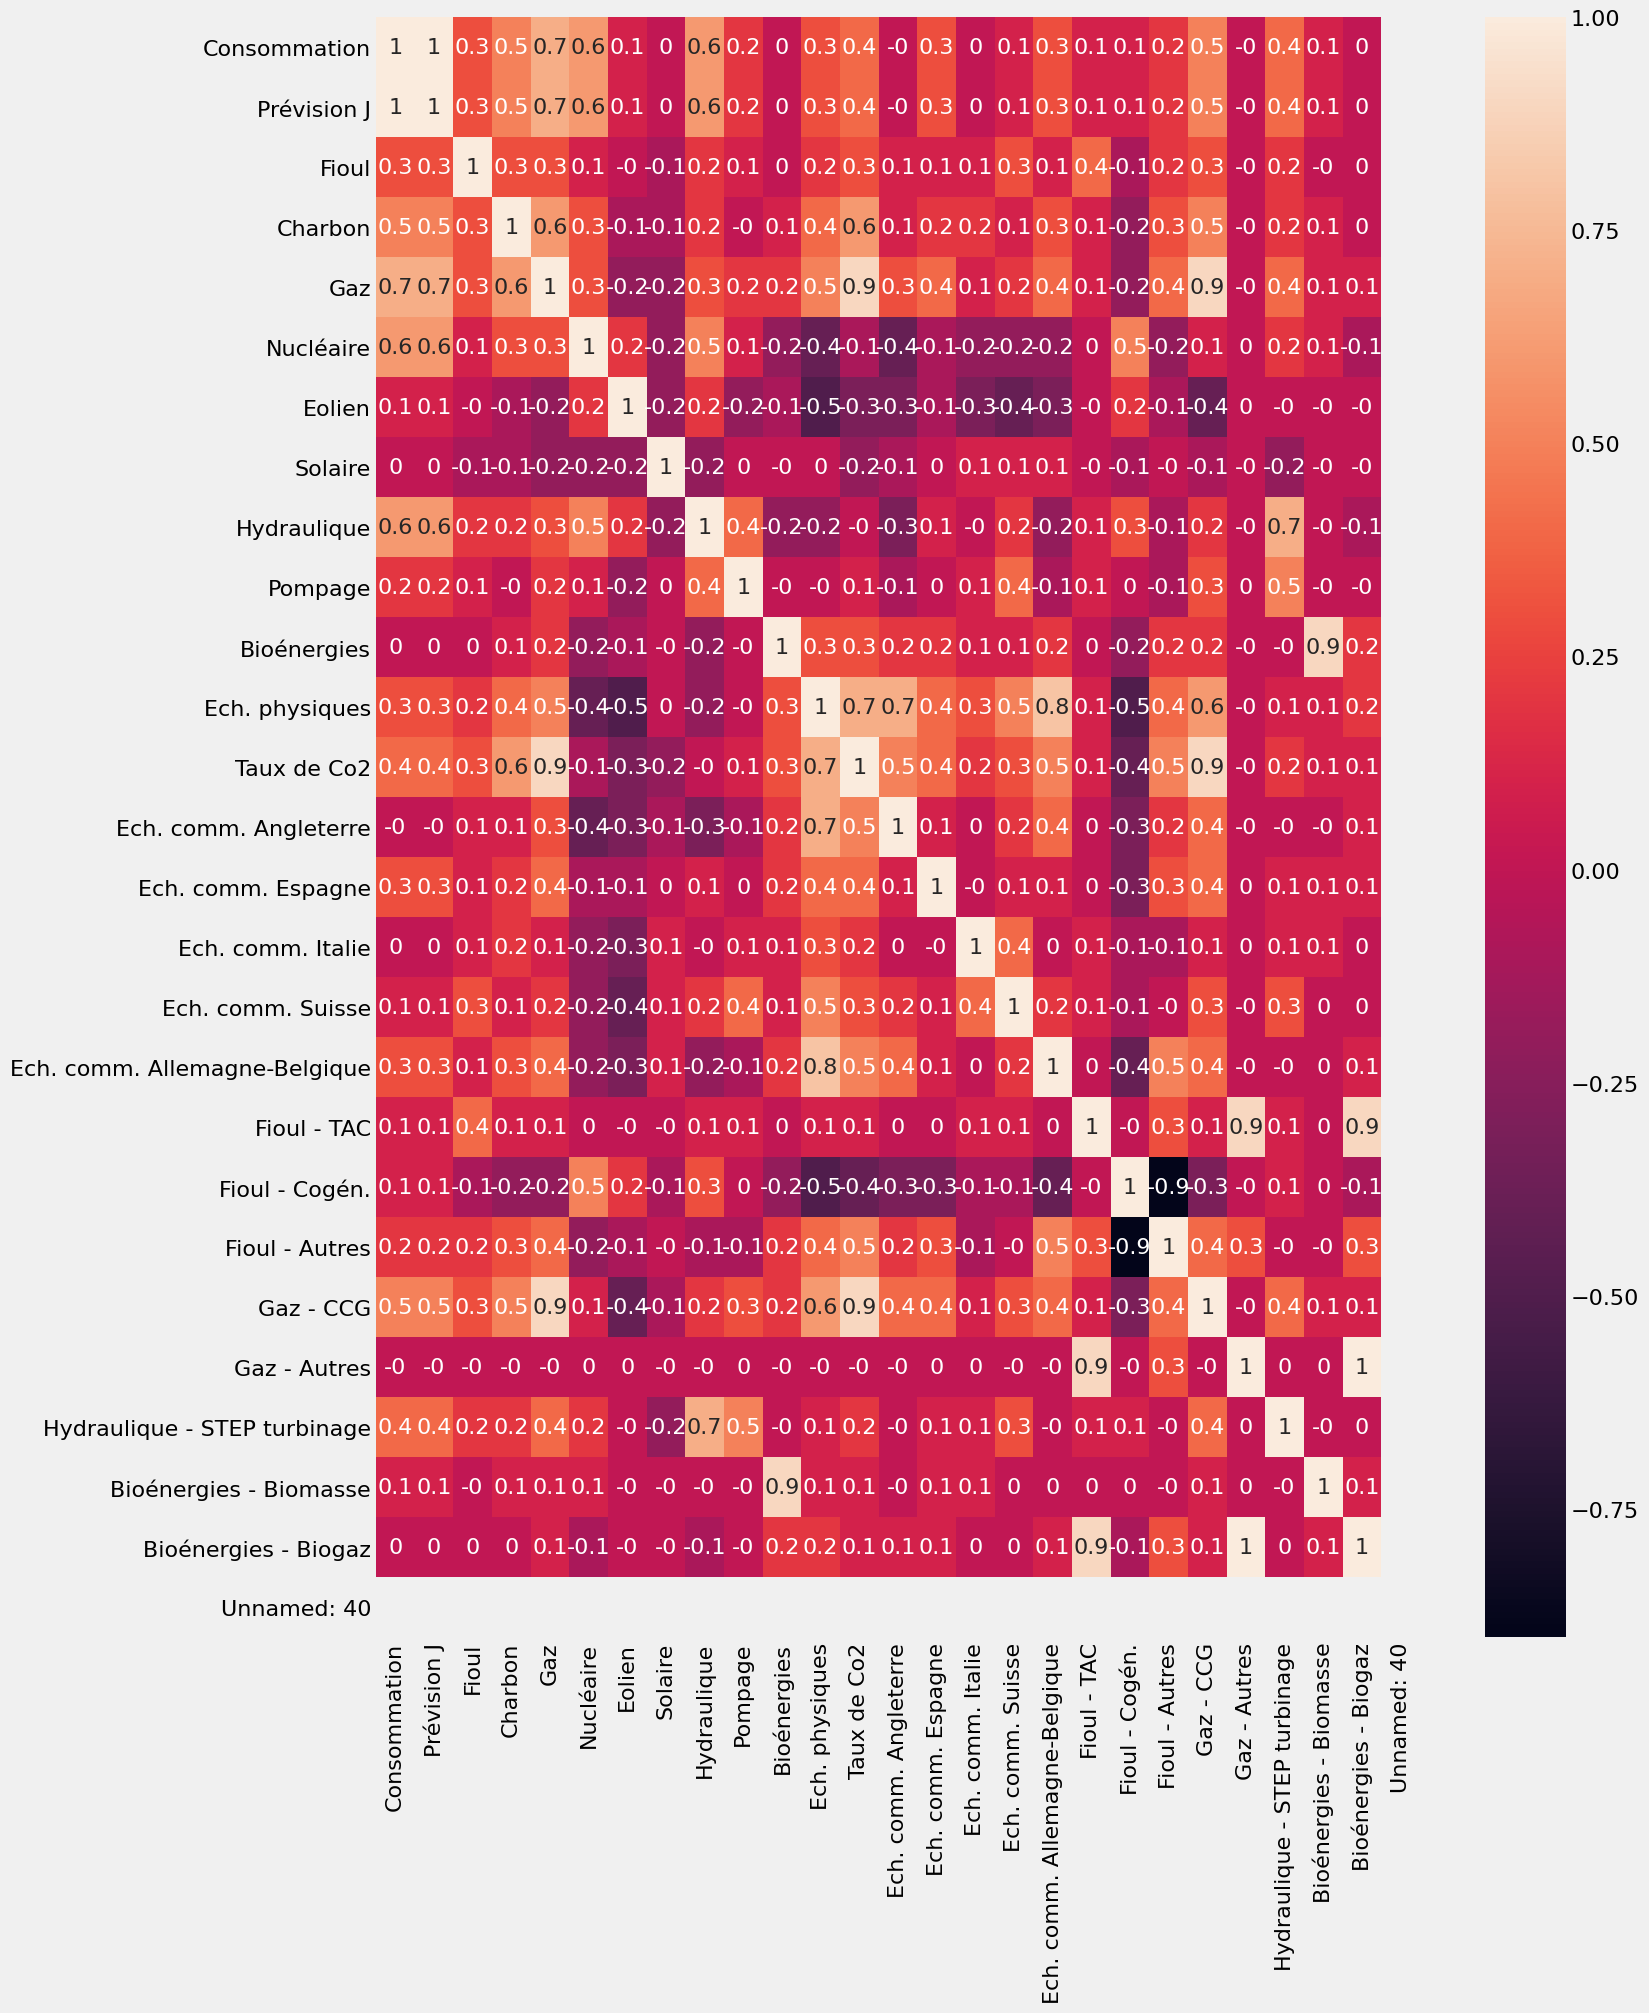

In [111]:
plt.figure(figsize=(15, 20))
sns.heatmap(np.round(EnCours_Temps_R.corr(method="pearson"),1), annot=True)
plt.show()

In [112]:
EnCours_Temps_R[-230:].head(50)

Périmètre              Nature        Date Heures  Consommation  \
57275    France  Données temps réel  2024-01-18  14:45       68208.0   
57276    France  Données temps réel  2024-01-18  15:00       67868.0   
57277    France  Données temps réel  2024-01-18  15:15       67745.0   
57278    France  Données temps réel  2024-01-18  15:30       67143.0   
57279    France  Données temps réel  2024-01-18  15:45           NaN   
57280    France  Données temps réel  2024-01-18  16:00           NaN   
57281    France  Données temps réel  2024-01-18  16:15           NaN   
57282    France  Données temps réel  2024-01-18  16:30           NaN   
57283    France  Données temps réel  2024-01-18  16:45           NaN   
57284    France  Données temps réel  2024-01-18  17:00           NaN   
57285    France  Données temps réel  2024-01-18  17:15           NaN   
57286    France  Données temps réel  2024-01-18  17:30           NaN   
57287    France  Données temps réel  2024-01-18  17:45           NaN   
57288    France  Données temps réel  2024-01-18  18:00           NaN   
57289    France  Données temps réel  2024-01-18  18:15           NaN   
57290    France  Données temps réel  2024-01-18  18:30           NaN   
57291    France  Données temps réel  2024-01-18  18:45           NaN   
57292    France  Données temps réel  2024-01-18  19:00           NaN   
57293    France  Données temps réel  2024-01-18  19:15           NaN   
57294    France  Données temps réel  2024-01-18  19:30           NaN   
57295    France  Données temps réel  2024-01-18  19:45           NaN   
57296    France  Données temps réel  2024-01-18  20:00           NaN   
57297    France  Données temps réel  2024-01-18  20:15           NaN   
57298    France  Données temps réel  2024-01-18  20:30           NaN   
57299    France  Données temps réel  2024-01-18  20:45           NaN   
57300    France  Données temps réel  2024-01-18  21:00           NaN   
57301    France  Données temps réel  2024-01-18  21:15           NaN   
57302    France  Données temps réel  2024-01-18  21:30           NaN   
57303    France  Données temps réel  2024-01-18  21:45           NaN   
57304    France  Données temps réel  2024-01-18  22:00           NaN   
57305    France  Données temps réel  2024-01-18  22:15           NaN   
57306    France  Données temps réel  2024-01-18  22:30           NaN   
57307    France  Données temps réel  2024-01-18  22:45           NaN   
57308    France  Données temps réel  2024-01-18  23:00           NaN   
57309    France  Données temps réel  2024-01-18  23:15           NaN   
57310    France  Données temps réel  2024-01-18  23:30           NaN   
57311    France  Données temps réel  2024-01-18  23:45           NaN   
57312    France  Données temps réel  2024-01-19  00:00           NaN   
57313    France  Données temps réel  2024-01-19  00:15           NaN   
57314    France  Données temps réel  2024-01-19  00:30           NaN   
57315    France  Données temps réel  2024-01-19  00:45           NaN   
57316    France  Données temps réel  2024-01-19  01:00           NaN   
57317    France  Données temps réel  2024-01-19  01:15           NaN   
57318    France  Données temps réel  2024-01-19  01:30           NaN   
57319    France  Données temps réel  2024-01-19  01:45           NaN   
57320    France  Données temps réel  2024-01-19  02:00           NaN   
57321    France  Données temps réel  2024-01-19  02:15           NaN   
57322    France  Données temps réel  2024-01-19  02:30           NaN   
57323    France  Données temps réel  2024-01-19  02:45           NaN   
57324    France  Données temps réel  2024-01-19  03:00           NaN   

      Prévision J-1  Prévision J  Fioul  Charbon     Gaz  ...  \
57275         67100      68200.0  190.0      9.0  8029.0  ...   
57276         66900      68100.0  190.0     10.0  7818.0  ...   
57277         66650      67750.0  191.0      5.0  7892.0  ...   
57278         66400      67400.0  190.0      5.0  7956.0  ...   
57279   

On remarque que les lignes dépendent du moment de récupération du fichier (cf 23h30).
Mais que Prévision J fini à la journée même.

In [113]:
Temp_Dep.head()

date_obs code_insee_departement     departement   tmin   tmax   tmoy
0  2019-10-22                     21       Côte-d'Or  10.90  16.00  13.45
1  2019-10-22                     73          Savoie  11.70  18.65  15.18
2  2019-10-22                     29       Finistère   7.77  15.48  11.63
3  2019-10-22                     48          Lozère   9.70  16.50  13.10
4  2019-10-22                     49  Maine-et-Loire   4.40  15.10   9.75

In [114]:
Temp_Nationale.head()

horodate  temperature_realisee_lissee_degc  \
0  2024-01-17T20:00:00+00:00                               4.8   
1  2024-01-17T14:30:00+00:00                               5.8   
2  2024-01-17T12:30:00+00:00                               5.4   
3  2024-01-17T12:00:00+00:00                               5.4   
4  2024-01-17T08:30:00+00:00                               3.7   

   temperature_normale_lissee_degc  \
0                              4.9   
1                              6.0   
2                              5.8   
3                              5.7   
4                              4.5   

   temperature_realisee_lissee_temperature_normale_lissee_degc  \
0                                               -0.1             
1                                               -0.2             
2                                               -0.4             
3                                               -0.3             
4                                               -0.8             

   pseudo_rayonnement  annee  mois  jour annee_mois_jour  
0                28.0   2024     1    17      2024-01-17  
1                 8.0   2024     1    17      2024-01-17  
2                 4.0   2024     1    17      2024-01-17  
3                 3.0   2024     1    17      2024-01-17  
4                11.0   2024     1    17      2024-01-17

In [115]:
Tempo_RTE_2324.head()

Date Type de jour TEMPO
0  2023-09-01               BLEU
1  2023-09-02               BLEU
2  2023-09-03               BLEU
3  2023-09-04               BLEU
4  2023-09-05               BLEU

Les offres de fourniture d'électricité de type Tempo comportent différents niveaux de prix, variables en fonction de l'heure et des jours de l'année.

- Les jours rouges correspondent aux périodes de l'année où la consommation est forte,
- Les jours blancs à un niveau intermédiaire,
- Les jours bleus sont ceux de plus faible consommation.


## Création Data

In [116]:
EnCours_Consolide_preprocessed = preprocessing_RTE_encours(EnCours_Temps_R)

/Users/arthurdubs/code/GitHub_Projects/1_Prediction_Consommation_Electrique_Française/analyse/preproc_RTE.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['date_hour'] = pd.to_datetime(df_final['Date']+ " " + df_final['Heures'])
/Users/arthurdubs/code/GitHub_Projects/1_Prediction_Consommation_Electrique_Française/analyse/preproc_RTE.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['Date'] = pd.to_datetime(df_final['Date'])
/Users/arthurdubs/code/GitHub_Projects/1_Prediction_Conso

In [117]:
EnCours_Consolide_preprocessed.head(5)

Date    Heures           date_hour  Consommation
0 2022-06-01  00:00:00 2022-06-01 00:00:00       44940.0
1 2022-06-01  00:15:00 2022-06-01 00:15:00       43967.0
2 2022-06-01  00:30:00 2022-06-01 00:30:00       42514.0
3 2022-06-01  00:45:00 2022-06-01 00:45:00       41073.0
4 2022-06-01  01:00:00 2022-06-01 01:00:00       40359.0

J'ai remarque en relecture qu'ajouter Prévision J-1/PrévisionJ pourrait être intéressant, à valider.

## Température Nationale

In [118]:
df_temp = preproc_temperature_ENEDIS(Temp_Nationale)

/Users/arthurdubs/code/GitHub_Projects/1_Prediction_Consommation_Electrique_Française/analyse/preproc_RTE.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reduced['horodate'] = df_reduced['horodate'].map(lambda x : x[:-6])
/Users/arthurdubs/code/GitHub_Projects/1_Prediction_Consommation_Electrique_Française/analyse/preproc_RTE.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reduced['horodate'] = pd.to_datetime(df_reduced['horodate'],utc=False)
/Users/arthurdubs/code/GitHub_Projects/1_Predic

In [119]:
df_temp

date_hour  temperature_realisee_lissee_degc  annee  mois  jour
76660 2019-01-17 23:00:00                               5.3   2019     1    17
87647 2019-01-17 23:30:00                               5.3   2019     1    17
43837 2019-01-18 00:00:00                               5.3   2019     1    18
43836 2019-01-18 00:30:00                               5.2   2019     1    18
76659 2019-01-18 01:00:00                               5.2   2019     1    18
...                   ...                               ...    ...   ...   ...
35472 2024-01-17 20:30:00                               4.8   2024     1    17
35471 2024-01-17 21:00:00                               4.8   2024     1    17
12131 2024-01-17 21:30:00                               4.8   2024     1    17
35470 2024-01-17 22:00:00                               4.8   2024     1    17
72119 2024-01-17 22:30:00                               4.8   2024     1    17

[87648 rows x 5 columns]

## Add Column

In [120]:
EnCours_Consolide_preprocessed = add_weekday(EnCours_Consolide_preprocessed)
EnCours_Consolide_preprocessed

Date    Heures           date_hour  Consommation  weekday
0     2022-06-01  00:00:00 2022-06-01 00:00:00       44940.0        2
1     2022-06-01  00:15:00 2022-06-01 00:15:00       43967.0        2
2     2022-06-01  00:30:00 2022-06-01 00:30:00       42514.0        2
3     2022-06-01  00:45:00 2022-06-01 00:45:00       41073.0        2
4     2022-06-01  01:00:00 2022-06-01 01:00:00       40359.0        2
...          ...       ...                 ...           ...      ...
57274 2024-01-18  14:30:00 2024-01-18 14:30:00       67663.0        3
57275 2024-01-18  14:45:00 2024-01-18 14:45:00       68208.0        3
57276 2024-01-18  15:00:00 2024-01-18 15:00:00       67868.0        3
57277 2024-01-18  15:15:00 2024-01-18 15:15:00       67745.0        3
57278 2024-01-18  15:30:00 2024-01-18 15:30:00       67143.0        3

[57279 rows x 5 columns]

In [121]:
#Un peu plus long (4.5sec)
EnCours_Consolide_preprocessed = add_schoolholidays(EnCours_Consolide_preprocessed)
EnCours_Consolide_preprocessed

Date    Heures           date_hour  Consommation  weekday  \
0     2022-06-01  00:00:00 2022-06-01 00:00:00       44940.0        2   
1     2022-06-01  00:15:00 2022-06-01 00:15:00       43967.0        2   
2     2022-06-01  00:30:00 2022-06-01 00:30:00       42514.0        2   
3     2022-06-01  00:45:00 2022-06-01 00:45:00       41073.0        2   
4     2022-06-01  01:00:00 2022-06-01 01:00:00       40359.0        2   
...          ...       ...                 ...           ...      ...   
57274 2024-01-18  14:30:00 2024-01-18 14:30:00       67663.0        3   
57275 2024-01-18  14:45:00 2024-01-18 14:45:00       68208.0        3   
57276 2024-01-18  15:00:00 2024-01-18 15:00:00       67868.0        3   
57277 2024-01-18  15:15:00 2024-01-18 15:15:00       67745.0        3   
57278 2024-01-18  15:30:00 2024-01-18 15:30:00       67143.0        3   

       school_holiday  
0                   0  
1                   0  
2                   0  
3                   0  
4                   0  
...               ...  
57274               0  
57275               0  
57276               0  
57277               0  
57278               0  

[57279 rows x 6 columns]

In [122]:
EnCours_Consolide_preprocessed = add_public_holidays(EnCours_Consolide_preprocessed)
EnCours_Consolide_preprocessed

Date    Heures           date_hour  Consommation  weekday  \
0     2022-06-01  00:00:00 2022-06-01 00:00:00       44940.0        2   
1     2022-06-01  00:15:00 2022-06-01 00:15:00       43967.0        2   
2     2022-06-01  00:30:00 2022-06-01 00:30:00       42514.0        2   
3     2022-06-01  00:45:00 2022-06-01 00:45:00       41073.0        2   
4     2022-06-01  01:00:00 2022-06-01 01:00:00       40359.0        2   
...          ...       ...                 ...           ...      ...   
57274 2024-01-18  14:30:00 2024-01-18 14:30:00       67663.0        3   
57275 2024-01-18  14:45:00 2024-01-18 14:45:00       68208.0        3   
57276 2024-01-18  15:00:00 2024-01-18 15:00:00       67868.0        3   
57277 2024-01-18  15:15:00 2024-01-18 15:15:00       67745.0        3   
57278 2024-01-18  15:30:00 2024-01-18 15:30:00       67143.0        3   

       school_holiday  public_holiday  
0                   0               0  
1                   0               0  
2                   0               0  
3                   0               0  
4                   0               0  
...               ...             ...  
57274               0               0  
57275               0               0  
57276               0               0  
57277               0               0  
57278               0               0  

[57279 rows x 7 columns]

## Tempo

In [123]:
Tempo_RTE_2122_preproc = preproc_tempo(Tempo_RTE_2122)
Tempo_RTE_2223_preproc = preproc_tempo(Tempo_RTE_2223)
Tempo_RTE_2324_preproc = preproc_tempo(Tempo_RTE_2324)

In [124]:
tempo_global = pd.concat([Tempo_RTE_2122_preproc, Tempo_RTE_2223_preproc, Tempo_RTE_2324_preproc], axis=0)
tempo_global

Date Type de jour TEMPO
0   2021-09-01               BLEU
1   2021-09-02               BLEU
2   2021-09-03               BLEU
3   2021-09-04               BLEU
4   2021-09-05               BLEU
..         ...                ...
136 2024-01-15              ROUGE
137 2024-01-16              ROUGE
138 2024-01-17              BLANC
139 2024-01-18              ROUGE
140 2024-01-19              ROUGE

[871 rows x 2 columns]

# Merge Global

## Merge

In [125]:
conso_final_TR_merged = EnCours_Consolide_preprocessed.merge(df_temp,how='inner',on="date_hour")
conso_final_TR_merged

Date    Heures           date_hour  Consommation  weekday  \
0     2022-06-01  00:00:00 2022-06-01 00:00:00       44940.0        2   
1     2022-06-01  00:30:00 2022-06-01 00:30:00       42514.0        2   
2     2022-06-01  01:00:00 2022-06-01 01:00:00       40359.0        2   
3     2022-06-01  01:30:00 2022-06-01 01:30:00       40049.0        2   
4     2022-06-01  02:00:00 2022-06-01 02:00:00       39328.0        2   
...          ...       ...                 ...           ...      ...   
28601 2024-01-17  20:30:00 2024-01-17 20:30:00       67515.0        2   
28602 2024-01-17  21:00:00 2024-01-17 21:00:00       65217.0        2   
28603 2024-01-17  21:30:00 2024-01-17 21:30:00       63881.0        2   
28604 2024-01-17  22:00:00 2024-01-17 22:00:00       62791.0        2   
28605 2024-01-17  22:30:00 2024-01-17 22:30:00       63393.0        2   

       school_holiday  public_holiday  temperature_realisee_lissee_degc  \
0                   0               0                              15.9   
1                   0               0                              15.9   
2                   0               0                              15.8   
3                   0               0                              15.8   
4                   0               0                              15.7   
...               ...             ...                               ...   
28601               0               0                               4.8   
28602               0               0                               4.8   
28603               0               0                               4.8   
28604               0               0                               4.8   
28605               0               0                               4.8   

       annee  mois  jour  
0       2022     6     1  
1       2022     6     1  
2       2022     6     1  
3       2022     6     1  
4       2022     6     1  
...      ...   ...   ...  
28601   2024     1    17  
28602   2024     1    17  
28603   2024     1    17  
28604   2024     1    17  
28605   2024     1    17  

[28606 rows x 11 columns]

In [126]:
df_final = conso_final_TR_merged.merge(tempo_global,how='left',on='Date')
df_final

Date    Heures           date_hour  Consommation  weekday  \
0     2022-06-01  00:00:00 2022-06-01 00:00:00       44940.0        2   
1     2022-06-01  00:30:00 2022-06-01 00:30:00       42514.0        2   
2     2022-06-01  01:00:00 2022-06-01 01:00:00       40359.0        2   
3     2022-06-01  01:30:00 2022-06-01 01:30:00       40049.0        2   
4     2022-06-01  02:00:00 2022-06-01 02:00:00       39328.0        2   
...          ...       ...                 ...           ...      ...   
28601 2024-01-17  20:30:00 2024-01-17 20:30:00       67515.0        2   
28602 2024-01-17  21:00:00 2024-01-17 21:00:00       65217.0        2   
28603 2024-01-17  21:30:00 2024-01-17 21:30:00       63881.0        2   
28604 2024-01-17  22:00:00 2024-01-17 22:00:00       62791.0        2   
28605 2024-01-17  22:30:00 2024-01-17 22:30:00       63393.0        2   

       school_holiday  public_holiday  temperature_realisee_lissee_degc  \
0                   0               0                              15.9   
1                   0               0                              15.9   
2                   0               0                              15.8   
3                   0               0                              15.8   
4                   0               0                              15.7   
...               ...             ...                               ...   
28601               0               0                               4.8   
28602               0               0                               4.8   
28603               0               0                               4.8   
28604               0               0                               4.8   
28605               0               0                               4.8   

       annee  mois  jour Type de jour TEMPO  
0       2022     6     1              BLANC  
1       2022     6     1              BLANC  
2       2022     6     1              BLANC  
3       2022     6     1              BLANC  
4       2022     6     1              BLANC  
...      ...   ...   ...                ...  
28601   2024     1    17              BLANC  
28602   2024     1    17              BLANC  
28603   2024     1    17              BLANC  
28604   2024     1    17              BLANC  
28605   2024     1    17              BLANC  

[28606 rows x 12 columns]

## Présentation Dataframe finale

In [127]:
df_final

Date    Heures           date_hour  Consommation  weekday  \
0     2022-06-01  00:00:00 2022-06-01 00:00:00       44940.0        2   
1     2022-06-01  00:30:00 2022-06-01 00:30:00       42514.0        2   
2     2022-06-01  01:00:00 2022-06-01 01:00:00       40359.0        2   
3     2022-06-01  01:30:00 2022-06-01 01:30:00       40049.0        2   
4     2022-06-01  02:00:00 2022-06-01 02:00:00       39328.0        2   
...          ...       ...                 ...           ...      ...   
28601 2024-01-17  20:30:00 2024-01-17 20:30:00       67515.0        2   
28602 2024-01-17  21:00:00 2024-01-17 21:00:00       65217.0        2   
28603 2024-01-17  21:30:00 2024-01-17 21:30:00       63881.0        2   
28604 2024-01-17  22:00:00 2024-01-17 22:00:00       62791.0        2   
28605 2024-01-17  22:30:00 2024-01-17 22:30:00       63393.0        2   

       school_holiday  public_holiday  temperature_realisee_lissee_degc  \
0                   0               0                              15.9   
1                   0               0                              15.9   
2                   0               0                              15.8   
3                   0               0                              15.8   
4                   0               0                              15.7   
...               ...             ...                               ...   
28601               0               0                               4.8   
28602               0               0                               4.8   
28603               0               0                               4.8   
28604               0               0                               4.8   
28605               0               0                               4.8   

       annee  mois  jour Type de jour TEMPO  
0       2022     6     1              BLANC  
1       2022     6     1              BLANC  
2       2022     6     1              BLANC  
3       2022     6     1              BLANC  
4       2022     6     1              BLANC  
...      ...   ...   ...                ...  
28601   2024     1    17              BLANC  
28602   2024     1    17              BLANC  
28603   2024     1    17              BLANC  
28604   2024     1    17              BLANC  
28605   2024     1    17              BLANC  

[28606 rows x 12 columns]

In [128]:
df_final.head()

Date    Heures           date_hour  Consommation  weekday  \
0 2022-06-01  00:00:00 2022-06-01 00:00:00       44940.0        2   
1 2022-06-01  00:30:00 2022-06-01 00:30:00       42514.0        2   
2 2022-06-01  01:00:00 2022-06-01 01:00:00       40359.0        2   
3 2022-06-01  01:30:00 2022-06-01 01:30:00       40049.0        2   
4 2022-06-01  02:00:00 2022-06-01 02:00:00       39328.0        2   

   school_holiday  public_holiday  temperature_realisee_lissee_degc  annee  \
0               0               0                              15.9   2022   
1               0               0                              15.9   2022   
2               0               0                              15.8   2022   
3               0               0                              15.8   2022   
4               0               0                              15.7   2022   

   mois  jour Type de jour TEMPO  
0     6     1              BLANC  
1     6     1              BLANC  
2     6     1              BLANC  
3     6     1              BLANC  
4     6     1              BLANC

## Création de la Matrice de Correlation 

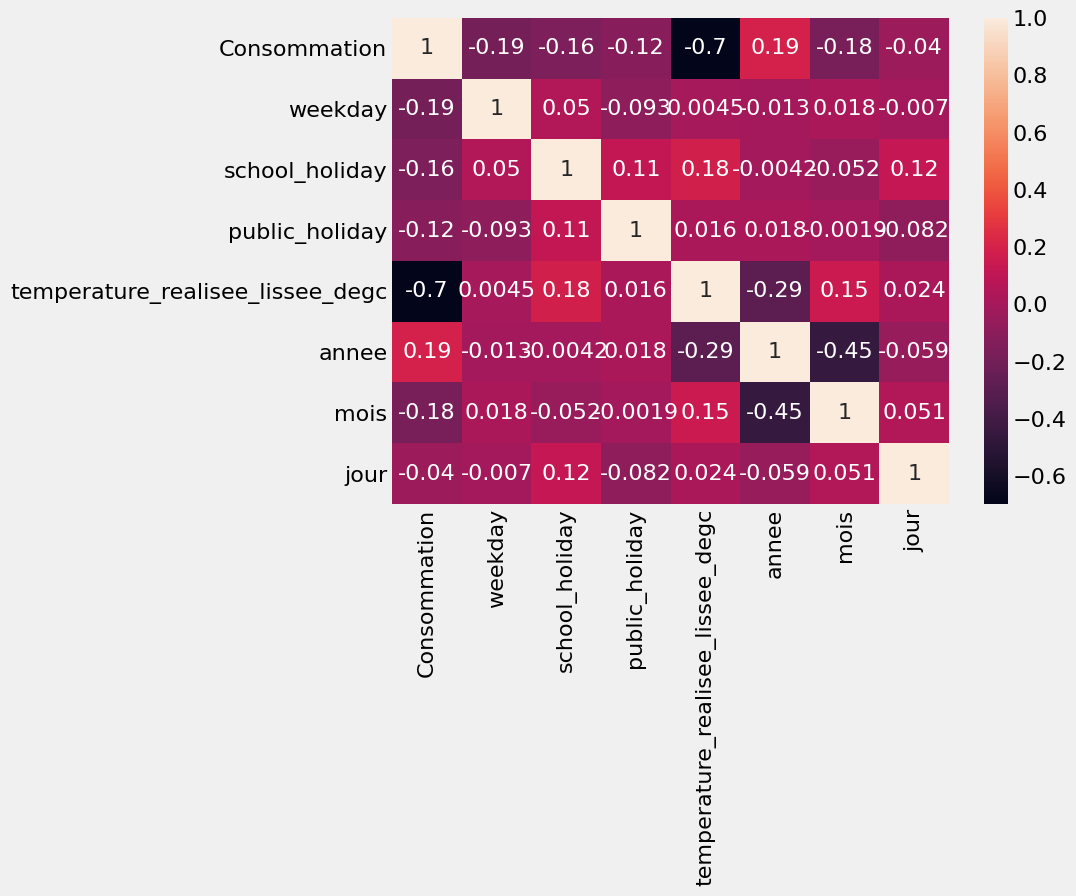

In [129]:
plt.figure(figsize=(8, 6))
sns.heatmap(df_final.corr(method="pearson"), annot=True)
plt.show()

# Mise en place Variable Circulaire + Anciennes données

## Circular Variable

In [130]:
df_final['hour'] = df_final['date_hour'].map(lambda x: x.hour)
df_final['minute'] = df_final['date_hour'].map(lambda x: x.minute)
df_final.drop(columns='date_hour',inplace=True)
df_final.drop(columns='Date',inplace=True)
df_final.drop(columns='Heures',inplace=True)
df_final

Consommation  weekday  school_holiday  public_holiday  \
0           44940.0        2               0               0   
1           42514.0        2               0               0   
2           40359.0        2               0               0   
3           40049.0        2               0               0   
4           39328.0        2               0               0   
...             ...      ...             ...             ...   
28601       67515.0        2               0               0   
28602       65217.0        2               0               0   
28603       63881.0        2               0               0   
28604       62791.0        2               0               0   
28605       63393.0        2               0               0   

       temperature_realisee_lissee_degc  annee  mois  jour Type de jour TEMPO  \
0                                  15.9   2022     6     1              BLANC   
1                                  15.9   2022     6     1              BLANC   
2                                  15.8   2022     6     1              BLANC   
3                                  15.8   2022     6     1              BLANC   
4                                  15.7   2022     6     1              BLANC   
...                                 ...    ...   ...   ...                ...   
28601                               4.8   2024     1    17              BLANC   
28602                               4.8   2024     1    17              BLANC   
28603                               4.8   2024     1    17              BLANC   
28604                               4.8   2024     1    17              BLANC   
28605                               4.8   2024     1    17              BLANC   

       hour  minute  
0         0       0  
1         0      30  
2         1       0  
3         1      30  
4         2       0  
...     ...     ...  
28601    20      30  
28602    21       0  
28603    21      30  
28604    22       0  
28605    22      30  

[28606 rows x 11 columns]

In [131]:
#mois
df_final['sin_month'] = df_final['mois'].apply(lambda h: np.sin(2 * np.pi * h / 12))
df_final['cos_month'] = df_final['mois'].apply(lambda h: np.cos(2 * np.pi * h / 12))
df_final.drop(['mois'], axis=1, inplace=True)

#Jour
df_final['sin_day'] = df_final['jour'].apply(lambda h: np.sin(2 * np.pi * h / 31))
df_final['cos_day'] = df_final['jour'].apply(lambda h: np.cos(2 * np.pi * h / 31))
df_final.drop(['jour'], axis=1, inplace=True)

#Heures
df_final['sin_hour'] = df_final['hour'].apply(lambda h: np.sin(2 * np.pi * h / 24))
df_final['cos_hour'] = df_final['hour'].apply(lambda h: np.cos(2 * np.pi * h / 24))
df_final.drop(['hour'], axis=1, inplace=True)

#Minutes
df_final['sin_minute'] = df_final['minute'].apply(lambda h: np.sin(2 * np.pi * h / 24))
df_final['cos_minute'] = df_final['minute'].apply(lambda h: np.cos(2 * np.pi * h / 24))
df_final.drop(['minute'], axis=1, inplace=True)

#Weekday
df_final['sin_weekday'] = df_final['weekday'].apply(lambda h: np.sin(2 * np.pi * h / 24))
df_final['cos_weekday'] = df_final['weekday'].apply(lambda h: np.cos(2 * np.pi * h / 24))
df_final.drop(['weekday'], axis=1, inplace=True)
df_final

Consommation  school_holiday  public_holiday  \
0           44940.0               0               0   
1           42514.0               0               0   
2           40359.0               0               0   
3           40049.0               0               0   
4           39328.0               0               0   
...             ...             ...             ...   
28601       67515.0               0               0   
28602       65217.0               0               0   
28603       63881.0               0               0   
28604       62791.0               0               0   
28605       63393.0               0               0   

       temperature_realisee_lissee_degc  annee Type de jour TEMPO  \
0                                  15.9   2022              BLANC   
1                                  15.9   2022              BLANC   
2                                  15.8   2022              BLANC   
3                                  15.8   2022              BLANC   
4                                  15.7   2022              BLANC   
...                                 ...    ...                ...   
28601                               4.8   2024              BLANC   
28602                               4.8   2024              BLANC   
28603                               4.8   2024              BLANC   
28604                               4.8   2024              BLANC   
28605                               4.8   2024              BLANC   

          sin_month  cos_month   sin_day   cos_day  sin_hour  cos_hour  \
0      1.224647e-16  -1.000000  0.201299  0.979530  0.000000  1.000000   
1      1.224647e-16  -1.000000  0.201299  0.979530  0.000000  1.000000   
2      1.224647e-16  -1.000000  0.201299  0.979530  0.258819  0.965926   
3      1.224647e-16  -1.000000  0.201299  0.979530  0.258819  0.965926   
4      1.224647e-16  -1.000000  0.201299  0.979530  0.500000  0.866025   
...             ...        ...       ...       ...       ...       ...   
28601  5.000000e-01   0.866025 -0.299363 -0.954139 -0.866025  0.500000   
28602  5.000000e-01   0.866025 -0.299363 -0.954139 -0.707107  0.707107   
28603  5.000000e-01   0.866025 -0.299363 -0.954139 -0.707107  0.707107   
28604  5.000000e-01   0.866025 -0.299363 -0.954139 -0.500000  0.866025   
28605  5.000000e-01   0.866025 -0.299363 -0.954139 -0.500000  0.866025   

       sin_minute    cos_minute  sin_weekday  cos_weekday  
0             0.0  1.000000e+00          0.5     0.866025  
1             1.0  1.194340e-15          0.5     0.866025  
2             0.0  1.000000e+00          0.5     0.866025  
3             1.0  1.194340e-15          0.5     0.866025  
4             0.0  1.000000e+00          0.5     0.866025  
...           ...           ...          ...          ...  
28601         1.0  1.194340e-15          0.5     0.866025  
28602         0.0  1.000000e+00          0.5     0.866025  
28603         1.0  1.194340e-15          0.5     0.866025  
28604         0.0  1.000000e+00          0.5     0.866025  
28605         1.0  1.194340e-15          0.5     0.866025  

[28606 rows x 16 columns]

## Lagged Variable

In [132]:
for i in range(1, 49):
    df_final[f'Conso_shift{i}'] = df_final["Consommation"].shift(i)

for i in range(1, 25):
    df_final[f'Temp_shift{i}'] = df_final["Consommation"].shift(i)

df_final.dropna(inplace=True)

In [133]:
df_final

Consommation  school_holiday  public_holiday  \
48          45208.0               0               0   
49          42420.0               0               0   
50          40356.0               0               0   
51          40299.0               0               0   
52          39840.0               0               0   
...             ...             ...             ...   
28601       67515.0               0               0   
28602       65217.0               0               0   
28603       63881.0               0               0   
28604       62791.0               0               0   
28605       63393.0               0               0   

       temperature_realisee_lissee_degc  annee Type de jour TEMPO  \
48                                 16.9   2022               BLEU   
49                                 16.9   2022               BLEU   
50                                 16.8   2022               BLEU   
51                                 16.8   2022               BLEU   
52                                 16.8   2022               BLEU   
...                                 ...    ...                ...   
28601                               4.8   2024              BLANC   
28602                               4.8   2024              BLANC   
28603                               4.8   2024              BLANC   
28604                               4.8   2024              BLANC   
28605                               4.8   2024              BLANC   

          sin_month  cos_month   sin_day   cos_day  ...  Temp_shift15  \
48     1.224647e-16  -1.000000  0.394356  0.918958  ...       48182.0   
49     1.224647e-16  -1.000000  0.394356  0.918958  ...       47927.0   
50     1.224647e-16  -1.000000  0.394356  0.918958  ...       47698.0   
51     1.224647e-16  -1.000000  0.394356  0.918958  ...       47906.0   
52     1.224647e-16  -1.000000  0.394356  0.918958  ...       48634.0   
...             ...        ...       ...       ...  ...           ...   
28601  5.000000e-01   0.866025 -0.299363 -0.954139  ...       71922.0   
28602  5.000000e-01   0.866025 -0.299363 -0.954139  ...       71408.0   
28603  5.000000e-01   0.866025 -0.299363 -0.954139  ...       71006.0   
28604  5.000000e-01   0.866025 -0.299363 -0.954139  ...       70555.0   
28605  5.000000e-01   0.866025 -0.299363 -0.954139  ...       70249.0   

       Temp_shift16  Temp_shift17  Temp_shift18  Temp_shift19  Temp_shift20  \
48          48644.0       49041.0       50002.0       50251.0       51061.0   
49          48182.0       48644.0       49041.0       50002.0       50251.0   
50          47927.0       48182.0       48644.0       49041.0       50002.0   
51          47698.0       47927.0       48182.0       48644.0       49041.0   
52          47906.0       47698.0       47927.0       48182.0       48644.0   
...             ...           ...           ...           ...           ...   
28601       73783.0       74726.0       74286.0       74076.0       74310.0   
28602       71922.0       73783.0       74726.0       74286.0       74076.0   
28603       71408.0       71922.0       73783.0       74726.0       74286.0   
28604       71006.0       71408.0       71922.0       73783.0       74726.0   
28605       70555.0       71006.0       71408.0       71922.0       73783.0   

       Temp_shift21  Temp_shift22  Temp_shift23  Temp_shift24  
48          51434.0       52071.0       52745.0       52351.0  
49          51061.0       51434.0       52071.0       52745.0  
50          50251.0       51061.0       51434.0       52071.0  
51          50002.0       50251.0       51061.0       51434.0  
52          49041.0       50002.0       50251.0       51061.0  
...             ...           ...           ...           ...  
28601       73674.0       73785.0       73203.0       72939.0  
28602       74310.0       73674.0       73785.0       73203.0  
28603       74076.0       74310.0       73674.0       73785.0  
28604       74286.0       74076.0       74310.0    

# Machine Learning

## Preprocessing pour ML

## OneHotEncoder TEMPO

In [134]:
from sklearn.preprocessing import OneHotEncoder
# Instantiate the OneHotEncoder
ohe = OneHotEncoder(sparse =False)

# Fit encoder
ohe.fit(df_final[['Type de jour TEMPO']])

# Display the detected categories
print(f"The categories detected by the OneHotEncoder are {ohe.categories_}")

# Transform the current "Street" column
df_final[ohe.get_feature_names_out()] = ohe.transform(df_final[['Type de jour TEMPO']])

# Drop the column "Street" which has been encoded
df_final.drop(columns = ["Type de jour TEMPO"], inplace = True)

# Show the dataset
df_final.head(3)

The categories detected by the OneHotEncoder are [array(['BLANC', 'BLEU', 'ROUGE'], dtype=object)]


/Users/arthurdubs/.pyenv/versions/3.10.6/envs/interviews/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Consommation  school_holiday  public_holiday  \
48       45208.0               0               0   
49       42420.0               0               0   
50       40356.0               0               0   

    temperature_realisee_lissee_degc  annee     sin_month  cos_month  \
48                              16.9   2022  1.224647e-16       -1.0   
49                              16.9   2022  1.224647e-16       -1.0   
50                              16.8   2022  1.224647e-16       -1.0   

     sin_day   cos_day  sin_hour  ...  Temp_shift18  Temp_shift19  \
48  0.394356  0.918958  0.000000  ...       50002.0       50251.0   
49  0.394356  0.918958  0.000000  ...       49041.0       50002.0   
50  0.394356  0.918958  0.258819  ...       48644.0       49041.0   

    Temp_shift20  Temp_shift21  Temp_shift22  Temp_shift23  Temp_shift24  \
48       51061.0       51434.0       52071.0       52745.0       52351.0   
49       50251.0       51061.0       51434.0       52071.0       52745.0   
50       50002.0       50251.0       51061.0       51434.0       52071.0   

    Type de jour TEMPO_BLANC  Type de jour TEMPO_BLEU  \
48                       0.0                      1.0   
49                       0.0                      1.0   
50                       0.0                      1.0   

    Type de jour TEMPO_ROUGE  
48                       0.0  
49                       0.0  
50                       0.0  

[3 rows x 90 columns]

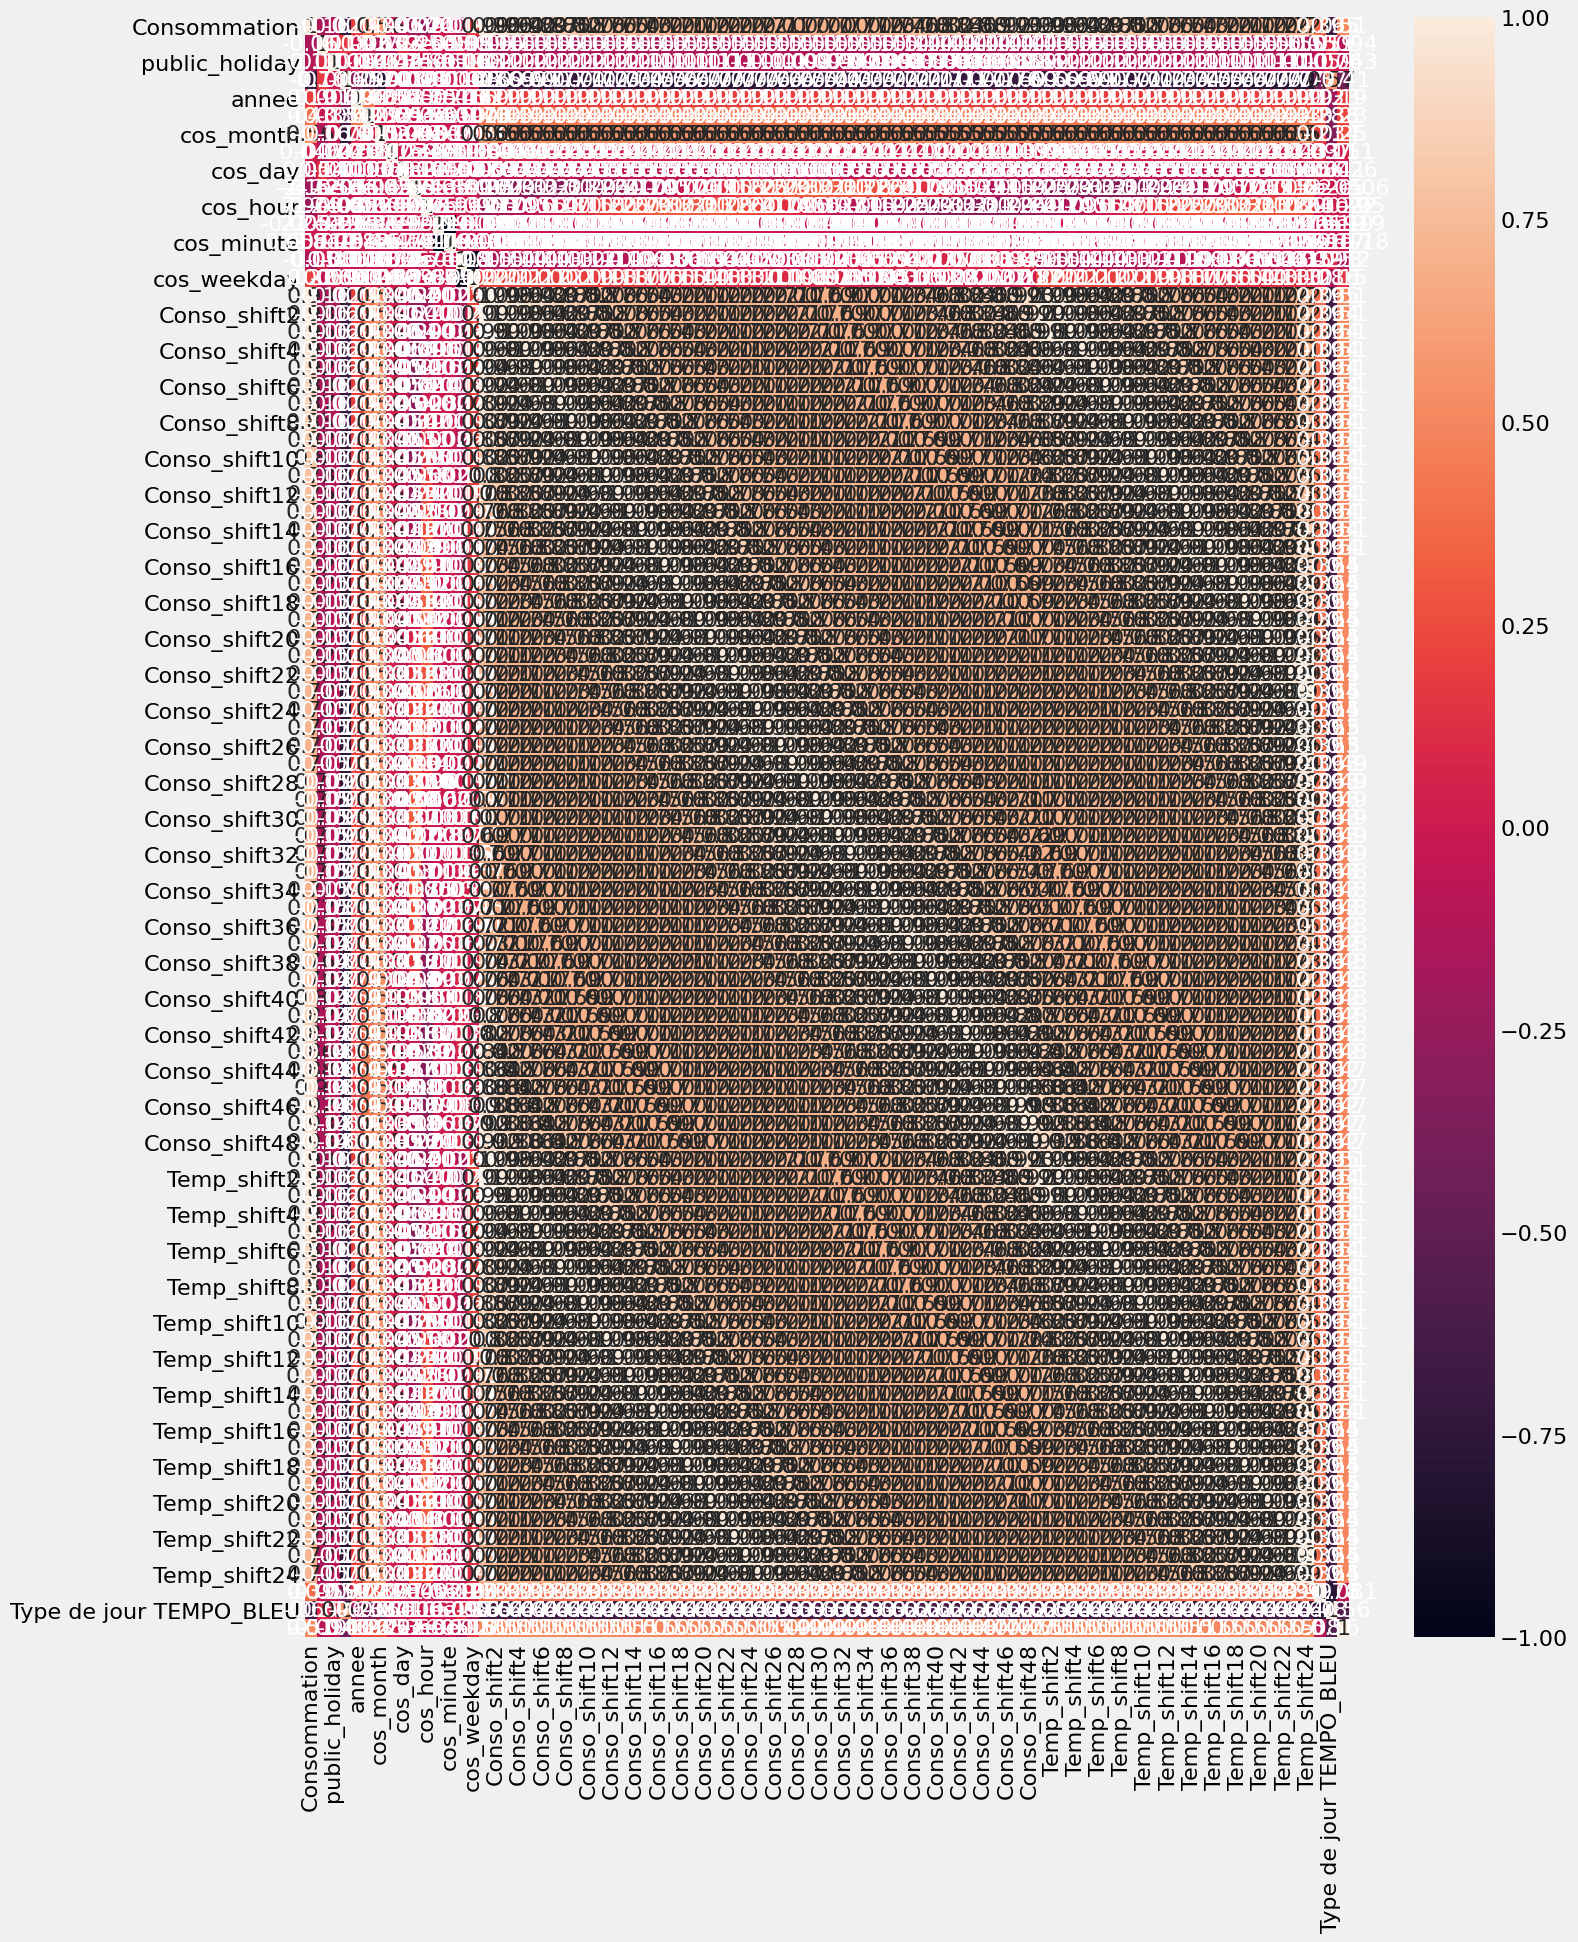

In [135]:
plt.figure(figsize=(15, 20))
sns.heatmap(df_final.corr(method="pearson"), annot=True)
plt.show()

## Train Test Split

In [136]:
n = 70 #Prédiction des 70 valeurs de fin, afin de récupérer la veille à 12h // conso_final_TR_merged.shape[0]
# A valider si modif de l'excel intial

train = df_final.iloc[:-n]
test = df_final.iloc[-n:]

X_train = train.drop(columns='Consommation')
y_train = train.Consommation

X_test = test.drop(columns='Consommation')
y_test = test.Consommation

print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(28488, 89) (70, 89) (28488,) (70,)


## Scaling

In [137]:
# Step 0 - Instanciate Robust Scale
rb_scaler = RobustScaler()

# Step 1- Fit the scaler
rb_scaler.fit(X_train)

# 2-Scale/Transform
X_train_scaled = rb_scaler.transform(X_train)
X_test_scaled = rb_scaler.transform(X_test)

#Possibilité de faire une Pipeline au besoin si
# l'on souhaite appliquer des scaleurs précis

In [138]:
train

Consommation  school_holiday  public_holiday  \
48          45208.0               0               0   
49          42420.0               0               0   
50          40356.0               0               0   
51          40299.0               0               0   
52          39840.0               0               0   
...             ...             ...             ...   
28531       80448.0               0               0   
28532       80178.0               0               0   
28533       79772.0               0               0   
28534       78740.0               0               0   
28535       78135.0               0               0   

       temperature_realisee_lissee_degc  annee     sin_month  cos_month  \
48                                 16.9   2022  1.224647e-16  -1.000000   
49                                 16.9   2022  1.224647e-16  -1.000000   
50                                 16.8   2022  1.224647e-16  -1.000000   
51                                 16.8   2022  1.224647e-16  -1.000000   
52                                 16.8   2022  1.224647e-16  -1.000000   
...                                 ...    ...           ...        ...   
28531                               1.4   2024  5.000000e-01   0.866025   
28532                               1.7   2024  5.000000e-01   0.866025   
28533                               2.0   2024  5.000000e-01   0.866025   
28534                               2.4   2024  5.000000e-01   0.866025   
28535                               2.7   2024  5.000000e-01   0.866025   

        sin_day   cos_day  sin_hour  ...  Temp_shift18  Temp_shift19  \
48     0.394356  0.918958  0.000000  ...       50002.0       50251.0   
49     0.394356  0.918958  0.000000  ...       49041.0       50002.0   
50     0.394356  0.918958  0.258819  ...       48644.0       49041.0   
51     0.394356  0.918958  0.258819  ...       48182.0       48644.0   
52     0.394356  0.918958  0.500000  ...       47927.0       48182.0   
...         ...       ...       ...  ...           ...           ...   
28531 -0.101168 -0.994869  0.707107  ...       67812.0       69224.0   
28532 -0.101168 -0.994869  0.500000  ...       66231.0       67812.0   
28533 -0.101168 -0.994869  0.500000  ...       66752.0       66231.0   
28534 -0.101168 -0.994869  0.258819  ...       66658.0       66752.0   
28535 -0.101168 -0.994869  0.258819  ...       66594.0       66658.0   

       Temp_shift20  Temp_shift21  Temp_shift22  Temp_shift23  Temp_shift24  \
48          51061.0       51434.0       52071.0       52745.0       52351.0   
49          50251.0       51061.0       51434.0       52071.0       52745.0   
50          50002.0       50251.0       51061.0       51434.0       52071.0   
51          49041.0       50002.0       50251.0       51061.0       51434.0   
52          48644.0       49041.0       50002.0       50251.0       51061.0   
...             ...           ...           ...           ...           ...   
28531       69631.0       70366.0       69703.0       68989.0       69863.0   
28532       69224.0       69631.0       70366.0       69703.0       68989.0   
28533       67812.0       69224.0       69631.0       70366.0       69703.0   
28534       66231.0       67812.0       69224.0       69631.0       70366.0   
28535       66752.0       66231.0       67812.0       69224.0       69631.0   

       Type de jour TEMPO_BLANC  Type de jour TEMPO_BLEU  \
48                          0.0                      1.0   
49                          0.0                      1.0   
50                          0.0                      1.0   
51                          0.0                      1.0   
52                          0.0                      1.0   
...                         ...                      ...   
28531                       0.0                      0.0   
28532                       0.0                      0.0   
28533                       0.0                      0.0   
28534                       0.0

## Modélisation 1 : HistGradientBoostingRegressor

/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_60769/1163403234.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["predictions"] = regressor.predict(X_test_scaled)


<AxesSubplot:>

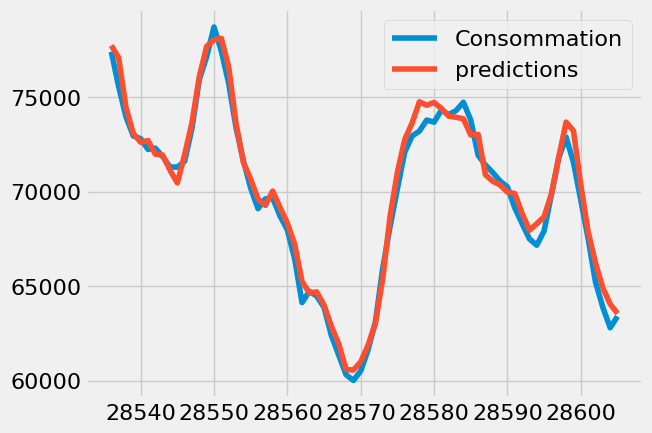

In [139]:
#0.6sec
regressor = HistGradientBoostingRegressor(min_samples_leaf=1)
regressor.fit(X_train_scaled, y_train)

test["predictions"] = regressor.predict(X_test_scaled)
test[['Consommation','predictions']].plot()

## Essayer d'ajouter les bonnes valeurs des heures pour meilleures compréhension

In [140]:
test

Consommation  school_holiday  public_holiday  \
28536       77402.0               0               0   
28537       75562.0               0               0   
28538       73957.0               0               0   
28539       72945.0               0               0   
28540       72800.0               0               0   
...             ...             ...             ...   
28601       67515.0               0               0   
28602       65217.0               0               0   
28603       63881.0               0               0   
28604       62791.0               0               0   
28605       63393.0               0               0   

       temperature_realisee_lissee_degc  annee  sin_month  cos_month  \
28536                               3.1   2024        0.5   0.866025   
28537                               3.2   2024        0.5   0.866025   
28538                               3.2   2024        0.5   0.866025   
28539                               3.2   2024        0.5   0.866025   
28540                               3.3   2024        0.5   0.866025   
...                                 ...    ...        ...        ...   
28601                               4.8   2024        0.5   0.866025   
28602                               4.8   2024        0.5   0.866025   
28603                               4.8   2024        0.5   0.866025   
28604                               4.8   2024        0.5   0.866025   
28605                               4.8   2024        0.5   0.866025   

        sin_day   cos_day      sin_hour  ...  Temp_shift19  Temp_shift20  \
28536 -0.101168 -0.994869  1.224647e-16  ...       66594.0       66658.0   
28537 -0.101168 -0.994869  1.224647e-16  ...       65321.0       66594.0   
28538 -0.101168 -0.994869 -2.588190e-01  ...       64898.0       65321.0   
28539 -0.101168 -0.994869 -2.588190e-01  ...       64144.0       64898.0   
28540 -0.101168 -0.994869 -5.000000e-01  ...       63994.0       64144.0   
...         ...       ...           ...  ...           ...           ...   
28601 -0.299363 -0.954139 -8.660254e-01  ...       74076.0       74310.0   
28602 -0.299363 -0.954139 -7.071068e-01  ...       74286.0       74076.0   
28603 -0.299363 -0.954139 -7.071068e-01  ...       74726.0       74286.0   
28604 -0.299363 -0.954139 -5.000000e-01  ...       73783.0       74726.0   
28605 -0.299363 -0.954139 -5.000000e-01  ...       71922.0       73783.0   

       Temp_shift21  Temp_shift22  Temp_shift23  Temp_shift24  \
28536       66752.0       66231.0       67812.0       69224.0   
28537       66658.0       66752.0       66231.0       67812.0   
28538       66594.0       66658.0       66752.0       66231.0   
28539       65321.0       66594.0       66658.0       66752.0   
28540       64898.0       65321.0       66594.0       66658.0   
...             ...           ...           ...           ...   
28601       73674.0       73785.0       73203.0       72939.0   
28602       74310.0       73674.0       73785.0       73203.0   
28603       74076.0       74310.0       73674.0       73785.0   
28604       74286.0       74076.0       74310.0       73674.0   
28605       74726.0       74286.0       74076.0       74310.0   

       Type de jour TEMPO_BLANC  Type de jour TEMPO_BLEU  \
28536                       0.0                      0.0   
28537                       0.0                      0.0   
28538                       0.0                      0.0   
28539                       0.0                      0.0   
28540                       0.0                      0.0   
...                         ...                      ...   
28601                       1.0                      0.0   
28602                       1.0                      0.0   
28603                       1.0                      0.0   
28604                       1.0                      0.0   
28605                       1.0                      0.0   

       Type de jour TEMPO_ROUGE   predictions  
28536             

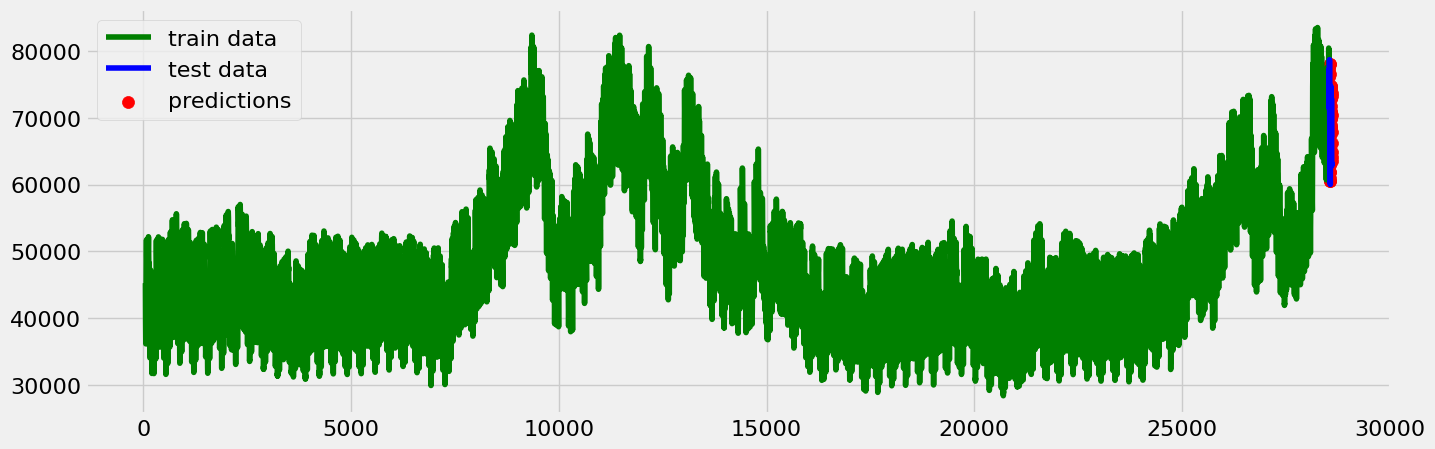

In [141]:
#Fig Globale
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(train.index,train["Consommation"], label='train data', color="green")
ax.plot(test.index,test["Consommation"], label='test data', color="blue")
#ax.plot(test.index, test["predictions"],  label='predictions', color="red")
ax.scatter(test.index, test["predictions"], label='predictions', color="red", s=75)
ax.legend(loc="upper left")

plt.show();

In [142]:
MAE_HGBR = mean_squared_error(test["Consommation"],test["predictions"])
MAPE_HGBR = mean_absolute_percentage_error(test["Consommation"],test["predictions"])

print('MSE = %.4g' % mean_squared_error(test["Consommation"],test["predictions"]))
print('MAPE = %.4g' % mean_absolute_percentage_error(test["Consommation"],test["predictions"]))

MSE = 4.413e+05
MAPE = 0.007839


In [143]:
# Ante-Circular/Shift Values
print('MSE = %.4g' % mean_squared_error(test["Consommation"],test["predictions"]))
print('MAPE = %.4g' % mean_absolute_percentage_error(test["Consommation"],test["predictions"]))

MSE = 4.413e+05
MAPE = 0.007839


Conlusion :
    - Bon modèle dans notre cas car le maximum situé au milie de la courbe lui donne une "référence" de cette zone de consommation. Dans le cas ou il n irait pas aussi haut, la courbe est restreinte au maximum qu'il a rencontré dans le train (exemple ci dessous)

#### Exemple Train trop faible

/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_60769/3319880666.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["predictions_less_data"] = regressor.predict(X_test_scaled)


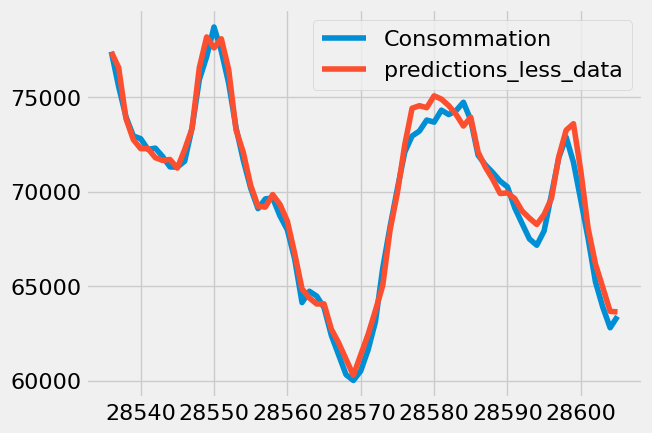

In [144]:
regressor = HistGradientBoostingRegressor(min_samples_leaf=1)
regressor.fit(X_train_scaled[20000:], y_train[20000:])

test["predictions_less_data"] = regressor.predict(X_test_scaled)
test[['Consommation','predictions_less_data']].plot();

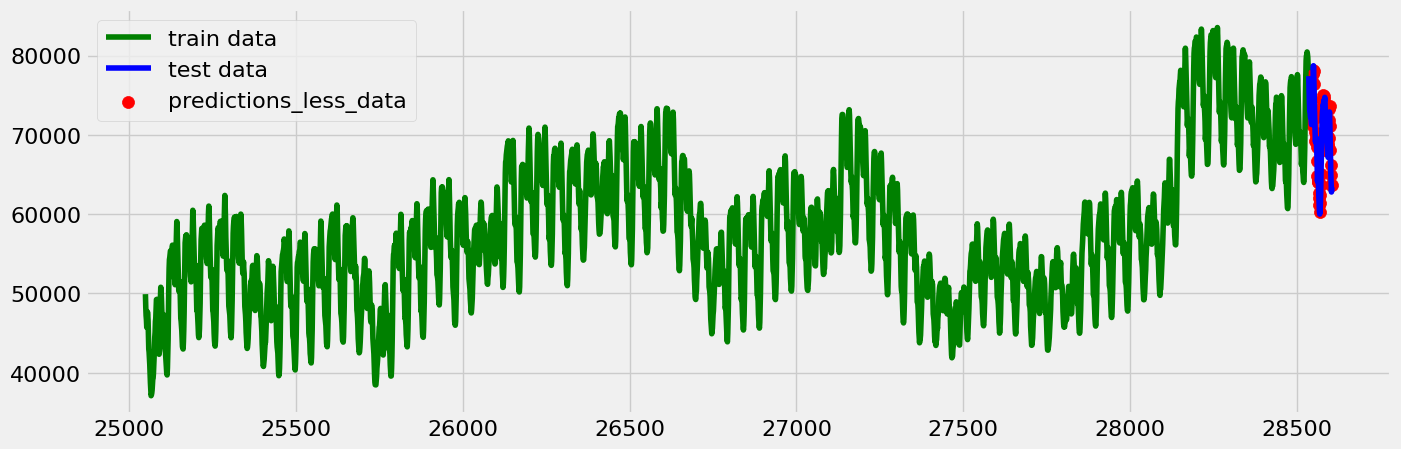

In [145]:
train_zoom = train[25000:]
test_zoom = test[:]

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(train_zoom.index,train_zoom["Consommation"], label='train data', color="green")
ax.plot(test_zoom.index,test_zoom["Consommation"], label='test data', color="blue")
#ax.plot(test.index, test["predictions"],  label='predictions', color="red")
ax.scatter(test_zoom.index, test_zoom["predictions_less_data"], label='predictions_less_data', color="red", s=75)
ax.legend(loc="upper left")
plt.show();

In [146]:
print('MSE = %.4g' % mean_squared_error(test["Consommation"],test["predictions_less_data"]))
print('MSE = %.4g' % mean_absolute_percentage_error(test["Consommation"],test["predictions_less_data"]))

MSE = 4.973e+05
MSE = 0.00813


## Modélisation 2 : avec LinearBoostRegressor

https://github.com/cerlymarco/linear-tree

In [178]:
#5 min30sec
regressor = LinearBoostRegressor(base_estimator=LinearRegression(),
                                 n_estimators = 100,
                                 max_depth    = 3,
                                 random_state = 42)

regressor.fit(X_train_scaled, y_train)
test["predictions_Linear"] = regressor.predict(X_test_scaled)

/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_60769/3535987623.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["predictions_Linear"] = regressor.predict(X_test_scaled)


In [148]:
df_final

Consommation  school_holiday  public_holiday  \
48          45208.0               0               0   
49          42420.0               0               0   
50          40356.0               0               0   
51          40299.0               0               0   
52          39840.0               0               0   
...             ...             ...             ...   
28601       67515.0               0               0   
28602       65217.0               0               0   
28603       63881.0               0               0   
28604       62791.0               0               0   
28605       63393.0               0               0   

       temperature_realisee_lissee_degc  annee     sin_month  cos_month  \
48                                 16.9   2022  1.224647e-16  -1.000000   
49                                 16.9   2022  1.224647e-16  -1.000000   
50                                 16.8   2022  1.224647e-16  -1.000000   
51                                 16.8   2022  1.224647e-16  -1.000000   
52                                 16.8   2022  1.224647e-16  -1.000000   
...                                 ...    ...           ...        ...   
28601                               4.8   2024  5.000000e-01   0.866025   
28602                               4.8   2024  5.000000e-01   0.866025   
28603                               4.8   2024  5.000000e-01   0.866025   
28604                               4.8   2024  5.000000e-01   0.866025   
28605                               4.8   2024  5.000000e-01   0.866025   

        sin_day   cos_day  sin_hour  ...  Temp_shift18  Temp_shift19  \
48     0.394356  0.918958  0.000000  ...       50002.0       50251.0   
49     0.394356  0.918958  0.000000  ...       49041.0       50002.0   
50     0.394356  0.918958  0.258819  ...       48644.0       49041.0   
51     0.394356  0.918958  0.258819  ...       48182.0       48644.0   
52     0.394356  0.918958  0.500000  ...       47927.0       48182.0   
...         ...       ...       ...  ...           ...           ...   
28601 -0.299363 -0.954139 -0.866025  ...       74286.0       74076.0   
28602 -0.299363 -0.954139 -0.707107  ...       74726.0       74286.0   
28603 -0.299363 -0.954139 -0.707107  ...       73783.0       74726.0   
28604 -0.299363 -0.954139 -0.500000  ...       71922.0       73783.0   
28605 -0.299363 -0.954139 -0.500000  ...       71408.0       71922.0   

       Temp_shift20  Temp_shift21  Temp_shift22  Temp_shift23  Temp_shift24  \
48          51061.0       51434.0       52071.0       52745.0       52351.0   
49          50251.0       51061.0       51434.0       52071.0       52745.0   
50          50002.0       50251.0       51061.0       51434.0       52071.0   
51          49041.0       50002.0       50251.0       51061.0       51434.0   
52          48644.0       49041.0       50002.0       50251.0       51061.0   
...             ...           ...           ...           ...           ...   
28601       74310.0       73674.0       73785.0       73203.0       72939.0   
28602       74076.0       74310.0       73674.0       73785.0       73203.0   
28603       74286.0       74076.0       74310.0       73674.0       73785.0   
28604       74726.0       74286.0       74076.0       74310.0       73674.0   
28605       73783.0       74726.0       74286.0       74076.0       74310.0   

       Type de jour TEMPO_BLANC  Type de jour TEMPO_BLEU  \
48                          0.0                      1.0   
49                          0.0                      1.0   
50                          0.0                      1.0   
51                          0.0                      1.0   
52                          0.0                      1.0   
...                         ...                      ...   
28601                       1.0                      0.0   
28602                       1.0                      0.0   
28603                       1.0                      0.0   
28604                       1.0

<AxesSubplot:>

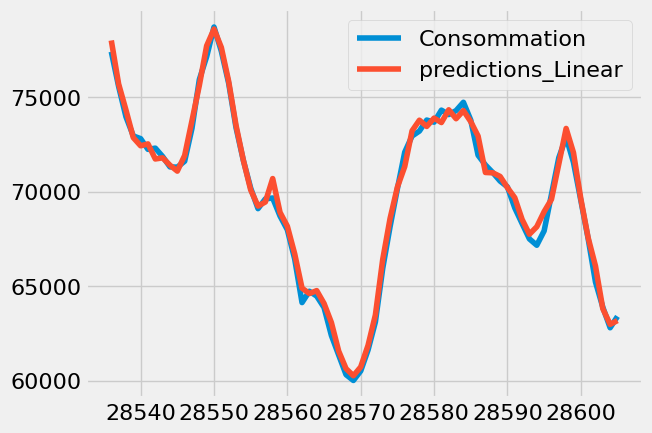

In [149]:
test[['Consommation','predictions_Linear']].plot()

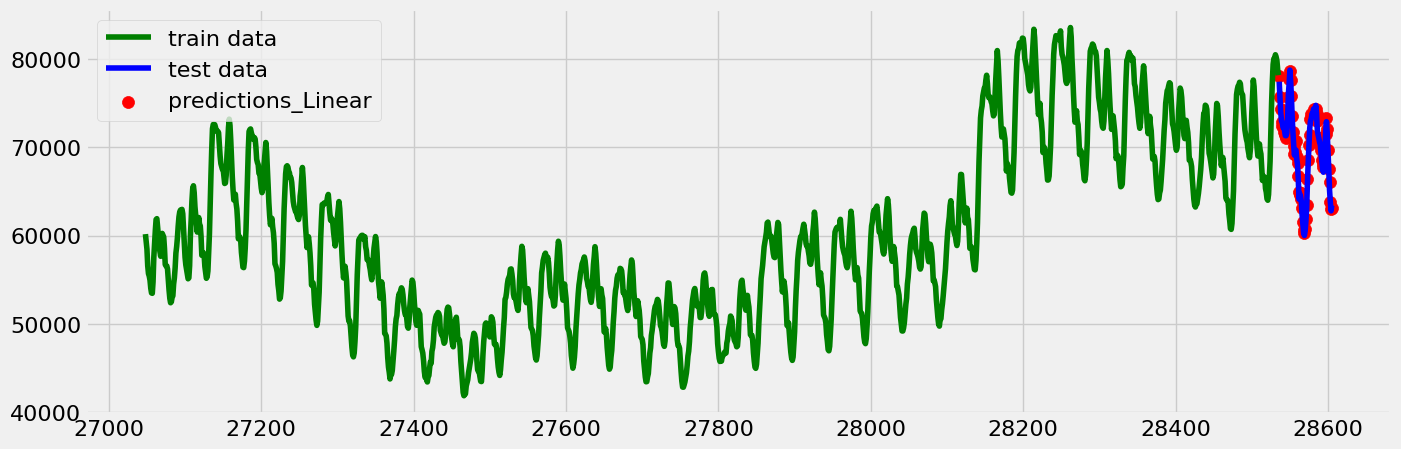

In [150]:
#Zoom sur l'ensemble
train_zoom = train[27000:]
test_zoom = test[:]

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(train_zoom.index,train_zoom["Consommation"], label='train data', color="green")
ax.plot(test_zoom.index,test_zoom["Consommation"], label='test data', color="blue")
#ax.plot(test.index, test["predictions"],  label='predictions', color="red")
ax.scatter(test_zoom.index, test_zoom["predictions_Linear"], label='predictions_Linear', color="red", s=75)
ax.legend(loc="upper left")
plt.show();

In [179]:
MAE_LBR = mean_squared_error(test["Consommation"],test["predictions_Linear"])
MAPE_LBR = mean_absolute_percentage_error(test["Consommation"],test["predictions_Linear"])

print('MSE = %.4g' % mean_squared_error(test["Consommation"],test["predictions_Linear"]))
print('MAPE = %.4g' % mean_absolute_percentage_error(test["Consommation"],test["predictions_Linear"]))

MSE = 2.589e+05
MAPE = 0.005641


In [151]:
MAE_LBR = mean_squared_error(test["Consommation"],test["predictions_Linear"])
MAPE_LBR = mean_absolute_percentage_error(test["Consommation"],test["predictions_Linear"])

print('MSE = %.4g' % mean_squared_error(test["Consommation"],test["predictions_Linear"]))
print('MAPE = %.4g' % mean_absolute_percentage_error(test["Consommation"],test["predictions_Linear"]))

MSE = 1.758e+05
MAPE = 0.004805


In [152]:
# Ante-Circular/Shift Values
print('MSE = %.4g' % mean_squared_error(test["Consommation"],test["predictions_Linear"]))
print('MAPE = %.4g' % mean_absolute_percentage_error(test["Consommation"],test["predictions_Linear"]))

MSE = 1.758e+05
MAPE = 0.004805


#### Exemple Train trop faible

In [153]:
regressor = LinearBoostRegressor(base_estimator=LinearRegression(),
                                 n_estimators = 300,
                                 max_depth    = 5,
                                 random_state = 42)

regressor.fit(X_train_scaled[20000:], y_train[20000:])
test["predictions_Linear_less_data"] = regressor.predict(X_test_scaled)


KeyboardInterrupt: 

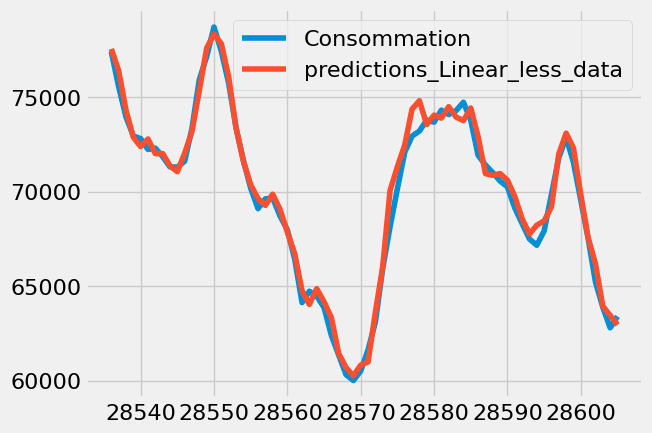

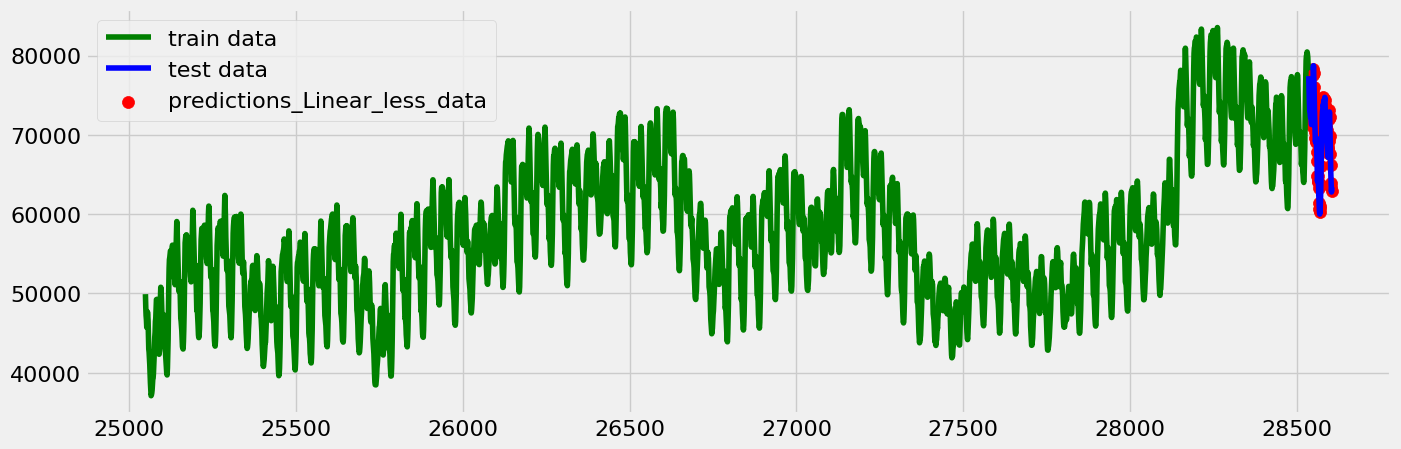

In [ ]:
test[['Consommation','predictions_Linear_less_data']].plot()

#Avec Zoom
train_zoom = train[25000:]
test_zoom = test[:]

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(train_zoom.index,train_zoom["Consommation"], label='train data', color="green")
ax.plot(test_zoom.index,test_zoom["Consommation"], label='test data', color="blue")
#ax.plot(test.index, test["predictions"],  label='predictions', color="red")
ax.scatter(test_zoom.index, test_zoom["predictions_Linear_less_data"], label='predictions_Linear_less_data', color="red", s=75)
ax.legend(loc="upper left")
plt.show();

In [ ]:
print('MSE = %.4g' % mean_squared_error(test["Consommation"],test["predictions_Linear_less_data"]))
print('MSE = %.4g' % mean_absolute_percentage_error(test["Consommation"],test["predictions_Linear_less_data"]))

MSE = 3.467e+05
MSE = 0.006646


## Modélisation 3 : GradientBoostingRegressor

/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_60769/2145090659.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["predictions_GBR"] = regressor.predict(X_test_scaled)


<AxesSubplot:>

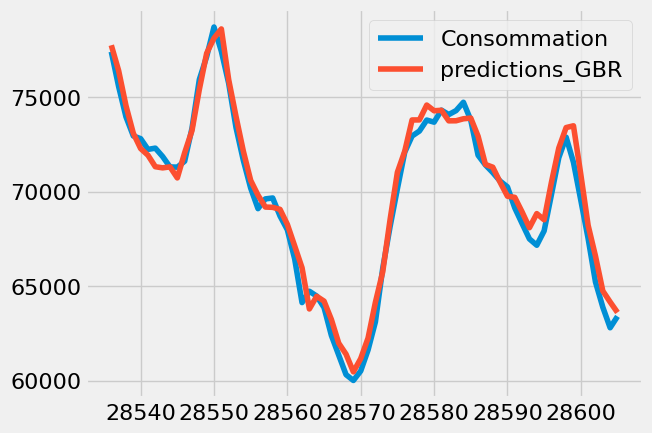

In [154]:
#0.6sec
regressor = GradientBoostingRegressor(n_estimators=200)
regressor.fit(X_train_scaled, y_train)

test["predictions_GBR"] = regressor.predict(X_test_scaled)
test[['Consommation','predictions_GBR']].plot()

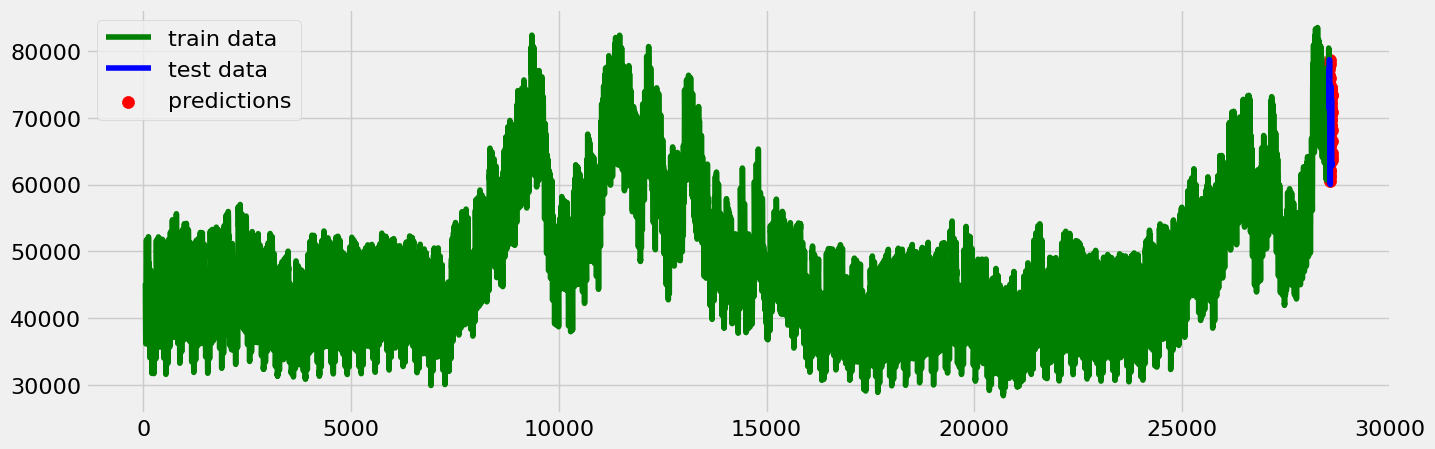

In [155]:
#Fig Globale
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(train.index,train["Consommation"], label='train data', color="green")
ax.plot(test.index,test["Consommation"], label='test data', color="blue")
#ax.plot(test.index, test["predictions"],  label='predictions', color="red")
ax.scatter(test.index, test["predictions_GBR"], label='predictions', color="red", s=75)
ax.legend(loc="upper left")

plt.show();

In [156]:
MAE_GBR = mean_squared_error(test["Consommation"],test["predictions_GBR"])
MAPE_GBR = mean_absolute_percentage_error(test["Consommation"],test["predictions_GBR"])


print('MSE = %.4g' % mean_squared_error(test["Consommation"],test["predictions_GBR"]))
print('MAPE = %.4g' % mean_absolute_percentage_error(test["Consommation"],test["predictions_GBR"]))

MSE = 5.408e+05
MAPE = 0.008839


## Modélisation 4 : XGBOOST

In [157]:
#import xgboost as xgb

In [158]:
# #0.6sec

# params = {
#     'objective': 'reg:squarederror',  # ou 'reg:squarederror' pour la régression
#     'max_depth': 3,
#     'learning_rate': 0.1,
#     'n_estimators': 100
# }

# dtrain = xgb.DMatrix(data=X_train_scaled, label=y_train)
# dtest = xgb.DMatrix(data=X_test_scaled, label=y_test)


# model = xgb.train(params=params, dtrain=dtrain)

# test["predictions"] = model.predict(dtest)
# test[['Consommation','predictions']].plot();

# ## Essayer d'ajouter les bonnes valeurs des heures pour meilleures compréhension

In [159]:
# #Fig Globale
# fig, ax = plt.subplots(1, 1, figsize=(15, 5))
# ax.plot(train.index,train["Consommation"], label='train data', color="green")
# ax.plot(test.index,test["Consommation"], label='test data', color="blue")
# #ax.plot(test.index, test["predictions"],  label='predictions', color="red")
# ax.scatter(test.index, test["predictions"], label='predictions', color="red", s=75)
# ax.legend(loc="upper left")

# plt.show();

In [160]:
# print('MSE = %.4g' % mean_squared_error(test["Consommation"],test["predictions"]))
# print('MAPE = %.4g' % mean_absolute_percentage_error(test["Consommation"],test["predictions"]))

## Modélisation 5 : Stats Forecast

# Conclusion

## Comparaison Résultat Singulier

In [170]:
MAE = [MAE_HGBR,MAE_LBR,MAE_GBR]
MAPE = 100*np.array([MAPE_HGBR,MAPE_LBR,MAPE_GBR])
mode = ['HGBR','LBR',"GBR"]
pd.DataFrame({"Modele":mode,"MAE":MAE,"MAPE (%)":MAPE}).sort_values('MAPE (%)')

Modele            MAE  MAPE (%)
1    LBR  175816.000951  0.480535
0   HGBR  441346.119414  0.783896
2    GBR  540841.295510  0.883893

On remarque que le Modèle le plus intéressant est le LBT cependant, il est assez lent. Le HGBR est plus rapide de part sa constryction (Bin) mais reste moins précis. Le GBR, est le moins précis sur cet exemple de dataset. Il serait intéressant de comparer leur précision sur un DataSet plus imposant et pas seulement sur 1 journée.

## Comparaison Résultat

In [171]:
df_final

Consommation  school_holiday  public_holiday  \
48          45208.0               0               0   
49          42420.0               0               0   
50          40356.0               0               0   
51          40299.0               0               0   
52          39840.0               0               0   
...             ...             ...             ...   
28601       67515.0               0               0   
28602       65217.0               0               0   
28603       63881.0               0               0   
28604       62791.0               0               0   
28605       63393.0               0               0   

       temperature_realisee_lissee_degc  annee     sin_month  cos_month  \
48                                 16.9   2022  1.224647e-16  -1.000000   
49                                 16.9   2022  1.224647e-16  -1.000000   
50                                 16.8   2022  1.224647e-16  -1.000000   
51                                 16.8   2022  1.224647e-16  -1.000000   
52                                 16.8   2022  1.224647e-16  -1.000000   
...                                 ...    ...           ...        ...   
28601                               4.8   2024  5.000000e-01   0.866025   
28602                               4.8   2024  5.000000e-01   0.866025   
28603                               4.8   2024  5.000000e-01   0.866025   
28604                               4.8   2024  5.000000e-01   0.866025   
28605                               4.8   2024  5.000000e-01   0.866025   

        sin_day   cos_day  sin_hour  ...  Temp_shift18  Temp_shift19  \
48     0.394356  0.918958  0.000000  ...       50002.0       50251.0   
49     0.394356  0.918958  0.000000  ...       49041.0       50002.0   
50     0.394356  0.918958  0.258819  ...       48644.0       49041.0   
51     0.394356  0.918958  0.258819  ...       48182.0       48644.0   
52     0.394356  0.918958  0.500000  ...       47927.0       48182.0   
...         ...       ...       ...  ...           ...           ...   
28601 -0.299363 -0.954139 -0.866025  ...       74286.0       74076.0   
28602 -0.299363 -0.954139 -0.707107  ...       74726.0       74286.0   
28603 -0.299363 -0.954139 -0.707107  ...       73783.0       74726.0   
28604 -0.299363 -0.954139 -0.500000  ...       71922.0       73783.0   
28605 -0.299363 -0.954139 -0.500000  ...       71408.0       71922.0   

       Temp_shift20  Temp_shift21  Temp_shift22  Temp_shift23  Temp_shift24  \
48          51061.0       51434.0       52071.0       52745.0       52351.0   
49          50251.0       51061.0       51434.0       52071.0       52745.0   
50          50002.0       50251.0       51061.0       51434.0       52071.0   
51          49041.0       50002.0       50251.0       51061.0       51434.0   
52          48644.0       49041.0       50002.0       50251.0       51061.0   
...             ...           ...           ...           ...           ...   
28601       74310.0       73674.0       73785.0       73203.0       72939.0   
28602       74076.0       74310.0       73674.0       73785.0       73203.0   
28603       74286.0       74076.0       74310.0       73674.0       73785.0   
28604       74726.0       74286.0       74076.0       74310.0       73674.0   
28605       73783.0       74726.0       74286.0       74076.0       74310.0   

       Type de jour TEMPO_BLANC  Type de jour TEMPO_BLEU  \
48                          0.0                      1.0   
49                          0.0                      1.0   
50                          0.0                      1.0   
51                          0.0                      1.0   
52                          0.0                      1.0   
...                         ...                      ...   
28601                       1.0                      0.0   
28602                       1.0                      0.0   
28603                       1.0                      0.0   
28604                       1.0

In [172]:
X = df_final.drop(columns='Consommation')
y = df_final.Consommation

In [183]:
regressor.predict(X_test_scaled).shape

(48,)

In [189]:
X = df_final.drop(columns='Consommation')
y = df_final[['Consommation']]

n_glob = X.shape[0]

MAE_HGBR_month = []
MAE_LBR_month = []
MAE_GBR_month = []

MAPE_HGBR_month = []
MAPE_LBR_month = []
MAPE_GBR_month = []

for k in range(30,0,-1):
    print(f"---------- Jour numéro {k} ----------")
    n_index = n_glob - 48*k

    X_train = X.iloc[:-n_index]
    X_test = X.iloc[-n_index:-n_index+48] #On effectue le test sur 30 jours

    y_train = y.iloc[:-n_index]
    y_test = y.iloc[-n_index:-n_index+48] #On effectue le test sur 30 jours

    # Step 0 - Instanciate Robust Scale
    rb_scaler = RobustScaler()
    # Step 1- Fit the scaler
    rb_scaler.fit(X_train)
    # 2-Scale/Transform
    X_train_scaled = rb_scaler.transform(X_train)
    X_test_scaled = rb_scaler.transform(X_test)

    ########Calcul#######
    #HGBR
    regressor = HistGradientBoostingRegressor(min_samples_leaf=1)
    regressor.fit(X_train_scaled, y_train)
    y_test["predictions_HGBR"] = regressor.predict(X_test_scaled)

    MAE_HGBR = mean_squared_error(y_test["Consommation"],y_test["predictions_HGBR"])
    MAPE_HGBR = mean_absolute_percentage_error(y_test["Consommation"],y_test["predictions_HGBR"])

    MAE_HGBR_month.append(MAE_HGBR)
    MAPE_HGBR_month.append(MAPE_HGBR)

    #LBR
    regressor = LinearBoostRegressor(base_estimator=LinearRegression(),
                                 n_estimators = 100,
                                 max_depth    = 3)

    regressor.fit(X_train_scaled, y_train)
    y_test["predictions_Linear"] = regressor.predict(X_test_scaled)

    MAE_LBR = mean_squared_error(y_test["Consommation"],y_test["predictions_Linear"])
    MAPE_LBR = mean_absolute_percentage_error(y_test["Consommation"],y_test["predictions_Linear"])

    MAE_LBR_month.append(MAE_LBR)
    MAPE_LBR_month.append(MAPE_LBR)

    #GBR
    regressor = GradientBoostingRegressor(n_estimators=200)
    regressor.fit(X_train_scaled, y_train)

    y_test["predictions_GBR"] = regressor.predict(X_test_scaled)

    MAE_GBR = mean_squared_error(y_test["Consommation"],y_test["predictions_GBR"])
    MAPE_GBR = mean_absolute_percentage_error(y_test["Consommation"],y_test["predictions_GBR"])

    MAE_GBR_month.append(MAE_GBR)
    MAPE_GBR_month.append(MAPE_GBR)


/Users/arthurdubs/.pyenv/versions/3.10.6/envs/interviews/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_60769/241382798.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_HGBR"] = regressor.predict(X_test_scaled)
/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_60769/241382798.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

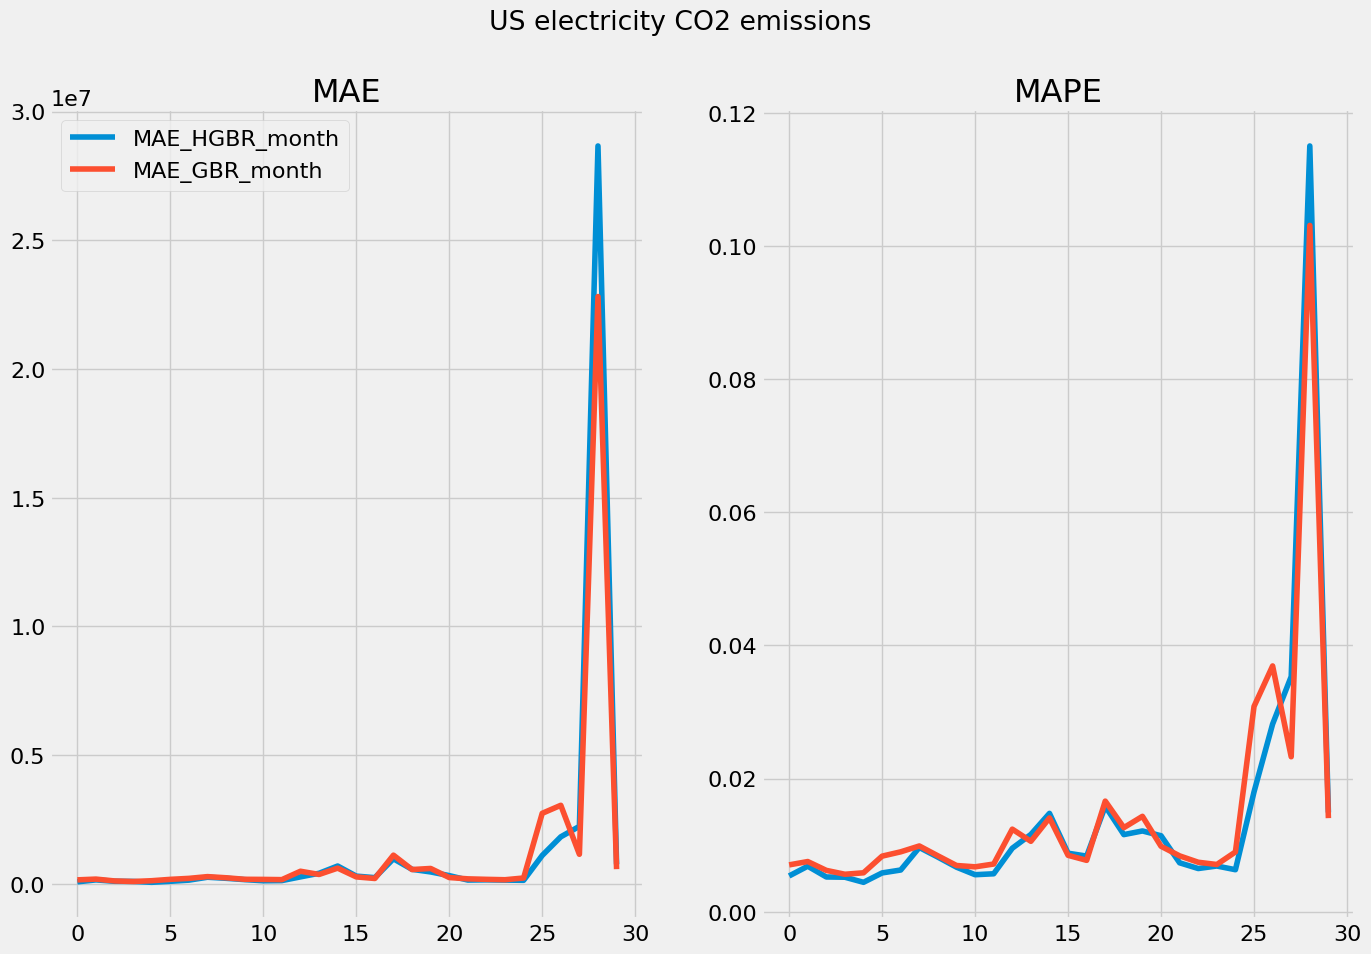

In [191]:
### Graphique de l'ensemble des Metrics ###

fig = plt.figure(figsize=(15,10))
fig = plt.gcf()

# First subplot
ax1 = fig.add_subplot(1,2,1)
ax1.plot(MAE_HGBR_month, label="MAE_HGBR_month")
#ax1.plot(MAE_LBR_month, label="MAE_LBR_month")
ax1.plot(MAE_GBR_month, label="MAE_GBR_month")
ax1.set_title('MAE')
ax1.legend()

# Second subplot
ax2 = fig.add_subplot(1,2,2)
ax2.plot(MAPE_HGBR_month, label="MAPE_HGBR_month")
#ax2.plot(MAPE_LBR_month, label="MAPE_LBR_month")
ax2.plot(MAPE_GBR_month, label="MAPE_GBR_month")
ax2.set_title('MAPE')

# Global figure methods
fig.suptitle('US electricity CO2 emissions')
plt.show()


On se rend compte que plus on se rapproche de la fin du Data Set, plus les modèles sont imprécis.
Est-ce le nombre de données qui augmente et qui influence la prédiction.

## Evolution du train sélectionné

In [193]:
X

school_holiday  public_holiday  temperature_realisee_lissee_degc  \
48                  0               0                              16.9   
49                  0               0                              16.9   
50                  0               0                              16.8   
51                  0               0                              16.8   
52                  0               0                              16.8   
...               ...             ...                               ...   
28601               0               0                               4.8   
28602               0               0                               4.8   
28603               0               0                               4.8   
28604               0               0                               4.8   
28605               0               0                               4.8   

       annee     sin_month  cos_month   sin_day   cos_day  sin_hour  cos_hour  \
48      2022  1.224647e-16  -1.000000  0.394356  0.918958  0.000000  1.000000   
49      2022  1.224647e-16  -1.000000  0.394356  0.918958  0.000000  1.000000   
50      2022  1.224647e-16  -1.000000  0.394356  0.918958  0.258819  0.965926   
51      2022  1.224647e-16  -1.000000  0.394356  0.918958  0.258819  0.965926   
52      2022  1.224647e-16  -1.000000  0.394356  0.918958  0.500000  0.866025   
...      ...           ...        ...       ...       ...       ...       ...   
28601   2024  5.000000e-01   0.866025 -0.299363 -0.954139 -0.866025  0.500000   
28602   2024  5.000000e-01   0.866025 -0.299363 -0.954139 -0.707107  0.707107   
28603   2024  5.000000e-01   0.866025 -0.299363 -0.954139 -0.707107  0.707107   
28604   2024  5.000000e-01   0.866025 -0.299363 -0.954139 -0.500000  0.866025   
28605   2024  5.000000e-01   0.866025 -0.299363 -0.954139 -0.500000  0.866025   

       ...  Temp_shift18  Temp_shift19  Temp_shift20  Temp_shift21  \
48     ...       50002.0       50251.0       51061.0       51434.0   
49     ...       49041.0       50002.0       50251.0       51061.0   
50     ...       48644.0       49041.0       50002.0       50251.0   
51     ...       48182.0       48644.0       49041.0       50002.0   
52     ...       47927.0       48182.0       48644.0       49041.0   
...    ...           ...           ...           ...           ...   
28601  ...       74286.0       74076.0       74310.0       73674.0   
28602  ...       74726.0       74286.0       74076.0       74310.0   
28603  ...       73783.0       74726.0       74286.0       74076.0   
28604  ...       71922.0       73783.0       74726.0       74286.0   
28605  ...       71408.0       71922.0       73783.0       74726.0   

       Temp_shift22  Temp_shift23  Temp_shift24  Type de jour TEMPO_BLANC  \
48          52071.0       52745.0       52351.0                       0.0   
49          51434.0       52071.0       52745.0                       0.0   
50          51061.0       51434.0       52071.0                       0.0   
51          50251.0       51061.0       51434.0                       0.0   
52          50002.0       50251.0       51061.0                       0.0   
...             ...           ...           ...                       ...   
28601       73785.0       73203.0       72939.0                       1.0   
28602       73674.0       73785.0       73203.0                       1.0   
28603       74310.0       73674.0       73785.0                       1.0   
28604       74076.0       74310.0       73674.0                       1.0   
28605       74286.0       74076.0       74310.0                       1.0   

       Type de jour TEMPO_BLEU  Type de jour TEMPO_ROUGE  
48                         1.0                       0.0  
49                         1.0                       0.0  
50                         1.0                       0.0  
51                         1.0                       0.0  
52                         1.0                       0.0  
...          

In [195]:
X[X['annee']>=2023]

school_holiday  public_holiday  temperature_realisee_lissee_degc  \
10272               1               1                              12.2   
10273               1               1                              12.2   
10274               1               1                              12.2   
10275               1               1                              12.2   
10276               1               1                              12.2   
...               ...             ...                               ...   
28601               0               0                               4.8   
28602               0               0                               4.8   
28603               0               0                               4.8   
28604               0               0                               4.8   
28605               0               0                               4.8   

       annee  sin_month  cos_month   sin_day   cos_day  sin_hour  cos_hour  \
10272   2023        0.5   0.866025  0.201299  0.979530  0.000000  1.000000   
10273   2023        0.5   0.866025  0.201299  0.979530  0.000000  1.000000   
10274   2023        0.5   0.866025  0.201299  0.979530  0.258819  0.965926   
10275   2023        0.5   0.866025  0.201299  0.979530  0.258819  0.965926   
10276   2023        0.5   0.866025  0.201299  0.979530  0.500000  0.866025   
...      ...        ...        ...       ...       ...       ...       ...   
28601   2024        0.5   0.866025 -0.299363 -0.954139 -0.866025  0.500000   
28602   2024        0.5   0.866025 -0.299363 -0.954139 -0.707107  0.707107   
28603   2024        0.5   0.866025 -0.299363 -0.954139 -0.707107  0.707107   
28604   2024        0.5   0.866025 -0.299363 -0.954139 -0.500000  0.866025   
28605   2024        0.5   0.866025 -0.299363 -0.954139 -0.500000  0.866025   

       ...  Temp_shift18  Temp_shift19  Temp_shift20  Temp_shift21  \
10272  ...       45975.0       46147.0       46158.0       46566.0   
10273  ...       45524.0       45975.0       46147.0       46158.0   
10274  ...       44738.0       45524.0       45975.0       46147.0   
10275  ...       44407.0       44738.0       45524.0       45975.0   
10276  ...       44992.0       44407.0       44738.0       45524.0   
...    ...           ...           ...           ...           ...   
28601  ...       74286.0       74076.0       74310.0       73674.0   
28602  ...       74726.0       74286.0       74076.0       74310.0   
28603  ...       73783.0       74726.0       74286.0       74076.0   
28604  ...       71922.0       73783.0       74726.0       74286.0   
28605  ...       71408.0       71922.0       73783.0       74726.0   

       Temp_shift22  Temp_shift23  Temp_shift24  Type de jour TEMPO_BLANC  \
10272       47681.0       47949.0       48297.0                       0.0   
10273       46566.0       47681.0       47949.0                       0.0   
10274       46158.0       46566.0       47681.0                       0.0   
10275       46147.0       46158.0       46566.0                       0.0   
10276       45975.0       46147.0       46158.0                       0.0   
...             ...           ...           ...                       ...   
28601       73785.0       73203.0       72939.0                       1.0   
28602       73674.0       73785.0       73203.0                       1.0   
28603       74310.0       73674.0       73785.0                       1.0   
28604       74076.0       74310.0       73674.0                       1.0   
28605       74286.0       74076.0       74310.0                       1.0   

       Type de jour TEMPO_BLEU  Type de jour TEMPO_ROUGE  
10272                      1.0                       0.0  
10273                      1.0                       0.0  
10274                      1.0                       0.0  
10275                      1.0                       0.0  
10276                      1.0                       0.0  
...                        ...                   

In [196]:
X = df_final[df_final['annee']>=2023].drop(columns='Consommation')
y = df_final[df_final['annee']>=2023][['Consommation']]

n_glob = X.shape[0]

MAE_HGBR_month = []
MAE_LBR_month = []
MAE_GBR_month = []

MAPE_HGBR_month = []
MAPE_LBR_month = []
MAPE_GBR_month = []

for k in range(15,0,-1):
    print(f"---------- Jour numéro {k} ----------")
    n_index = n_glob - 48*k

    X_train = X.iloc[:-n_index]
    X_test = X.iloc[-n_index:-n_index+48] #On effectue le test sur 30 jours

    y_train = y.iloc[:-n_index]
    y_test = y.iloc[-n_index:-n_index+48] #On effectue le test sur 30 jours

    # Step 0 - Instanciate Robust Scale
    rb_scaler = RobustScaler()
    # Step 1- Fit the scaler
    rb_scaler.fit(X_train)
    # 2-Scale/Transform
    X_train_scaled = rb_scaler.transform(X_train)
    X_test_scaled = rb_scaler.transform(X_test)

    ########Calcul#######
    #HGBR
    regressor = HistGradientBoostingRegressor(min_samples_leaf=1)
    regressor.fit(X_train_scaled, y_train)
    y_test["predictions_HGBR"] = regressor.predict(X_test_scaled)

    MAE_HGBR = mean_squared_error(y_test["Consommation"],y_test["predictions_HGBR"])
    MAPE_HGBR = mean_absolute_percentage_error(y_test["Consommation"],y_test["predictions_HGBR"])

    MAE_HGBR_month.append(MAE_HGBR)
    MAPE_HGBR_month.append(MAPE_HGBR)

    #LBR
    regressor = LinearBoostRegressor(base_estimator=LinearRegression(),
                                 n_estimators = 100,
                                 max_depth    = 3)

    regressor.fit(X_train_scaled, y_train)
    y_test["predictions_Linear"] = regressor.predict(X_test_scaled)

    MAE_LBR = mean_squared_error(y_test["Consommation"],y_test["predictions_Linear"])
    MAPE_LBR = mean_absolute_percentage_error(y_test["Consommation"],y_test["predictions_Linear"])

    MAE_LBR_month.append(MAE_LBR)
    MAPE_LBR_month.append(MAPE_LBR)

    #GBR
    regressor = GradientBoostingRegressor(n_estimators=200)
    regressor.fit(X_train_scaled, y_train)

    y_test["predictions_GBR"] = regressor.predict(X_test_scaled)

    MAE_GBR = mean_squared_error(y_test["Consommation"],y_test["predictions_GBR"])
    MAPE_GBR = mean_absolute_percentage_error(y_test["Consommation"],y_test["predictions_GBR"])

    MAE_GBR_month.append(MAE_GBR)
    MAPE_GBR_month.append(MAPE_GBR)


---------- Jour numéro 15 ----------


/Users/arthurdubs/.pyenv/versions/3.10.6/envs/interviews/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_60769/3660191324.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_HGBR"] = regressor.predict(X_test_scaled)
/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_60769/3660191324.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

---------- Jour numéro 14 ----------


/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_60769/3660191324.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_HGBR"] = regressor.predict(X_test_scaled)
/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_60769/3660191324.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_Linear"] = regressor.predict(X_test_scaled)
/Users/arthurdubs/.pyenv/versions/3.10.6/envs/interviews/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversio

---------- Jour numéro 13 ----------


/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_60769/3660191324.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_HGBR"] = regressor.predict(X_test_scaled)
/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_60769/3660191324.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_Linear"] = regressor.predict(X_test_scaled)
/Users/arthurdubs/.pyenv/versions/3.10.6/envs/interviews/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversio

---------- Jour numéro 12 ----------


/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_60769/3660191324.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_HGBR"] = regressor.predict(X_test_scaled)
/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_60769/3660191324.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_Linear"] = regressor.predict(X_test_scaled)
/Users/arthurdubs/.pyenv/versions/3.10.6/envs/interviews/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversio

---------- Jour numéro 11 ----------


/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_60769/3660191324.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_HGBR"] = regressor.predict(X_test_scaled)
/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_60769/3660191324.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_Linear"] = regressor.predict(X_test_scaled)
/Users/arthurdubs/.pyenv/versions/3.10.6/envs/interviews/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversio

---------- Jour numéro 10 ----------


/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_60769/3660191324.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_HGBR"] = regressor.predict(X_test_scaled)
/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_60769/3660191324.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_Linear"] = regressor.predict(X_test_scaled)
/Users/arthurdubs/.pyenv/versions/3.10.6/envs/interviews/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversio

---------- Jour numéro 9 ----------


/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_60769/3660191324.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_HGBR"] = regressor.predict(X_test_scaled)
/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_60769/3660191324.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_Linear"] = regressor.predict(X_test_scaled)
/Users/arthurdubs/.pyenv/versions/3.10.6/envs/interviews/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversio

---------- Jour numéro 8 ----------


/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_60769/3660191324.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_HGBR"] = regressor.predict(X_test_scaled)
/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_60769/3660191324.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_Linear"] = regressor.predict(X_test_scaled)
/Users/arthurdubs/.pyenv/versions/3.10.6/envs/interviews/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversio

---------- Jour numéro 7 ----------


/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_60769/3660191324.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_HGBR"] = regressor.predict(X_test_scaled)
/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_60769/3660191324.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_Linear"] = regressor.predict(X_test_scaled)
/Users/arthurdubs/.pyenv/versions/3.10.6/envs/interviews/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversio

---------- Jour numéro 6 ----------


/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_60769/3660191324.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_HGBR"] = regressor.predict(X_test_scaled)
/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_60769/3660191324.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_Linear"] = regressor.predict(X_test_scaled)
/Users/arthurdubs/.pyenv/versions/3.10.6/envs/interviews/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversio

---------- Jour numéro 5 ----------


/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_60769/3660191324.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_HGBR"] = regressor.predict(X_test_scaled)
/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_60769/3660191324.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_Linear"] = regressor.predict(X_test_scaled)
/Users/arthurdubs/.pyenv/versions/3.10.6/envs/interviews/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversio

---------- Jour numéro 4 ----------


/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_60769/3660191324.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_HGBR"] = regressor.predict(X_test_scaled)
/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_60769/3660191324.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_Linear"] = regressor.predict(X_test_scaled)
/Users/arthurdubs/.pyenv/versions/3.10.6/envs/interviews/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversio

---------- Jour numéro 3 ----------


/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_60769/3660191324.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_HGBR"] = regressor.predict(X_test_scaled)
/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_60769/3660191324.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_Linear"] = regressor.predict(X_test_scaled)
/Users/arthurdubs/.pyenv/versions/3.10.6/envs/interviews/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversio

---------- Jour numéro 2 ----------


/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_60769/3660191324.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_HGBR"] = regressor.predict(X_test_scaled)
/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_60769/3660191324.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_Linear"] = regressor.predict(X_test_scaled)
/Users/arthurdubs/.pyenv/versions/3.10.6/envs/interviews/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversio

---------- Jour numéro 1 ----------


/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_60769/3660191324.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_HGBR"] = regressor.predict(X_test_scaled)
/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_60769/3660191324.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_Linear"] = regressor.predict(X_test_scaled)
/Users/arthurdubs/.pyenv/versions/3.10.6/envs/interviews/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversio

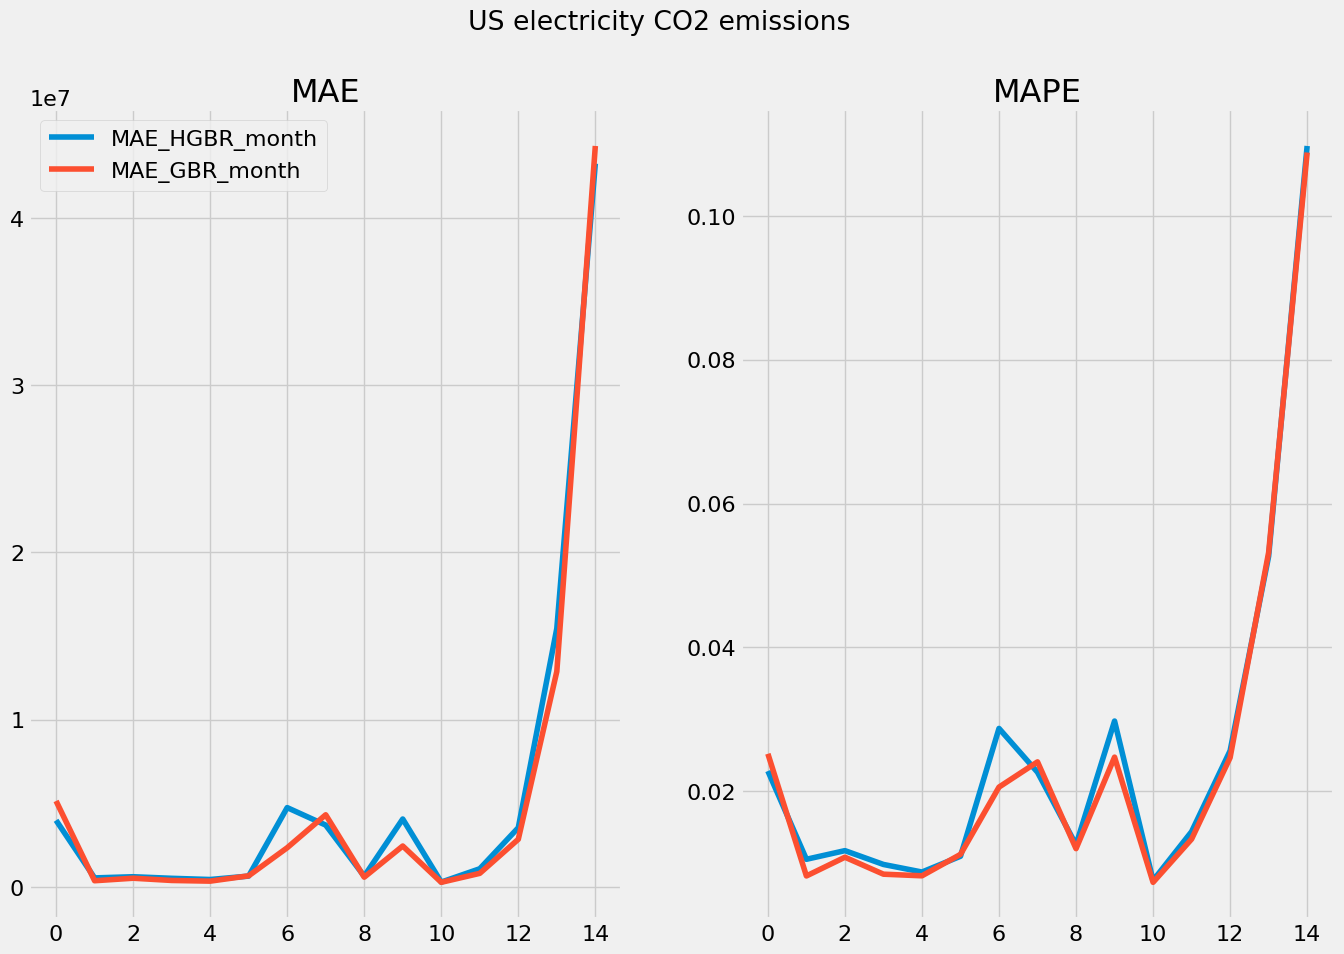

In [199]:
### Graphique de l'ensemble des Metrics ###

fig = plt.figure(figsize=(15,10))
fig = plt.gcf()

# First subplot
ax1 = fig.add_subplot(1,2,1)
ax1.plot(MAE_HGBR_month, label="MAE_HGBR_month")
#ax1.plot(MAE_LBR_month, label="MAE_LBR_month")
ax1.plot(MAE_GBR_month, label="MAE_GBR_month")
ax1.set_title('MAE')
ax1.legend()

# Second subplot
ax2 = fig.add_subplot(1,2,2)
ax2.plot(MAPE_HGBR_month, label="MAPE_HGBR_month")
#ax2.plot(MAPE_LBR_month, label="MAPE_LBR_month")
ax2.plot(MAPE_GBR_month, label="MAPE_GBR_month")
ax2.set_title('MAPE')

# Global figure methods
fig.suptitle('US electricity CO2 emissions')
plt.show()
